In [1]:

import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pathlib import Path
import numpy as np
# ---------
# torch.set_grad_enabled(False)
# ============================
#       Radom Seed
# ============================
seed = 99

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


# ============================
#       Equilibrium CNN
# ============================
def linear(x):
    # return F.hardsigmoid(x)
    return x
def hardtanh6(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = -6, max=6)
def hardtanh6_d(x):
        return ((x > -6) & (x < 6)).float()
def hardtanh(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = -1, max=1)
def hardtanh_d(x):
        return ((x > -1) & (x < 1)).float()
def hardsigm(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=1)
def hardsigm_d(x):
        return ((x > 0) & (x < 1)).float()
def relu6(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=6)
def relu6_d(x):
        return ((x > 0) & (x < 6)).float()
def relu(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0)
def relu_d(x):
        return ((x > 0)).float()

cuda:True
GPU 0:NVIDIA RTX A5000:23.99GB


### Dataset

In [2]:

fsave=True
current_time_start = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_path = Path(f"./Res/Final_conv_{current_time_start}-MNIST")
res_path.mkdir(parents=True, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(train_set, range(int(1 * len(train_set))))
test_subset = Subset(test_set, range(int(1 * len(test_set))))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=512, shuffle=False)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

criterion = nn.CrossEntropyLoss()

num_epochs = 40
multest = 1 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))





True
GPU 0:NVIDIA RTX A5000:23.99GB


### Network

In [ ]:


class aEP_CNN(nn.Module):
    def __init__(self, fbsc=0.1, nudge= 0.2, deviden=True, T=50, K=20, chl= [32, 64]):
        super().__init__()

        self.T = T
        self.K = K
        self.eta = 1 # leaky rate
        self.ffSC, self.fbSC, self.nudge = 1.0, fbsc, nudge
        self.chl = chl
        self.rho = hardsigm # hardsigm relu6 relu6 hardtanh hardtanh6 linear

        self.deviden = deviden

        self.conv1 = nn.Conv2d(1, self.chl[0], kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2, stride = 2, return_indices = True)  
        self.conv2 = nn.Conv2d(self.chl[0], self.chl[1], kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(2, stride = 2, return_indices = True)  
        self.fc1 = nn.Linear(self.chl[1] * 4 * 4, 10)

        self.unpool1 = nn.MaxUnpool2d(2, stride = 2)  
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)  

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    @torch.no_grad()
    def forward(self, x, t=0, s=0, nudge = 0, target=None):
        if t>0:
            x1, p1, ind1, x2, p2, ind2, fc1 = s  
        else:
            # x1, p1, ind1, x2, p2, ind2, x3 = 0, 0, 0, 0, 0, 0, 0
            x1 = self.conv1(torch.zeros_like(x,device=self.device))       # torch.zeros_like(x,device=self.device)
            p1, ind1 = self.pool1(self.rho(x1))
            x2 = self.conv2(p1)      # (B, 32, 16, 16)
            p2, ind2 = self.pool2(self.rho(x2))

            fc1 = ( self.fc1(p2.view(p2.size(0), -1)))
        
        # if nudge!=0:
        if nudge!=0: 
            fb =  (target-F.softmax(fc1,dim=1)) @ self.fc1.weight 
            fbs = fb.view(fb.size(0), self.chl[1], 4, 4)
        else:
            fbs = torch.zeros_like(p2,device=self.device)
        # else:
        #     fbs = torch.zeros_like(p2,device=self.device) F.conv_transpose2d(delta_conv4, self.conv2.weight, stride=1, padding=1) #.permute([0,1,3,2])
        dx1 =  (self.conv1(x)*self.ffSC +self.unpool1( F.conv_transpose2d(self.rho(x2), self.conv2.weight, stride=1, padding=0),
                                            ind1,output_size=x1.shape)*self.fbSC)
        p1, ind1 = self.pool1(self.rho(x1))       # output_size =(B, 128, 16, 16)
        
        dx2 =  (self.conv2(p1)*self.ffSC + self.unpool2(fbs,ind2,output_size=x2.shape)* nudge )
        p2, ind2 = self.pool2(self.rho(x2))      # (B, 256, 8, 8)

        dfc = ( self.fc1(p2.view(p2.size(0), -1)))

        x1 =dx1
        x2 =dx2
        fc1 = dfc
        # if nudge == 0: fc1 = dfc
        return x1, p1, ind1, x2, p2, ind2, fc1
    
    
    @torch.no_grad()
    def ep_step(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(self.device)

        # Free phase dynamics
        sf = 0
        
        # self.deconv2.bias.data = self.conv2.bias.clone()
        for t in range(self.T):
            sf = self.forward(x, t=t, s=sf, nudge=0, target=y_onehot)

        x1, p1, _, x2, p2, _, fc1 = sf
        # self.x1, self.x2, self.xfc1 = x1, x2, fc1
        preds = torch.argmax(sf[-1], dim=1)

        # Nudged phase dynamics
        sn = [t.clone() for t in sf]
        for t in range(self.K):
            sn = self.forward(x, t=self.T+t, s=sn, nudge=self.nudge, target=y_onehot)

        # Weight update: contrastive Hebbian rule (difference of activations)
        
        x1n, _, _, x2n, _, _, fc1n = sn

        # after free-phase we had: x1,x2,x3,x4 and p1,p2,p3,p4 and fc1 (free)
        # after nudged-phase sn we get x1n,...,x4n and p4n and fc1_nudged (sn[-1])
        beta = self.nudge if self.deviden else 1#
        
        # fc
        # delta_fc = (F.softmax(fc1, dim=1) - F.softmax(fc1n, dim=1)) / (beta * x.size(0))
        delta_fc = (F.softmax(fc1, dim=1) - y_onehot) / (x.size(0))
        flatp4 = p2.view(p2.size(0), -1).contiguous()
        self.fc1.weight.grad = delta_fc.T @ flatp4
        self.fc1.bias.grad = delta_fc.sum(0)


        # conv2
        delta_conv2 = ((self.rho(x2) - self.rho(x2n)) / ( self.fbSC**0 * beta * x.size(0))).contiguous()
        grad_conv2_w = torch.nn.grad.conv2d_weight(p1.contiguous(), self.conv2.weight.shape, delta_conv2, stride=1, padding=0)
        self.conv2.weight.grad = grad_conv2_w
        self.conv2.bias.grad = delta_conv2.sum(dim=(0,2,3))

        # conv1
        delta_conv1 = ((self.rho(x1) - self.rho(x1n)) / ( self.fbSC**0 * beta * x.size(0))).contiguous()
        grad_conv1_w = torch.nn.grad.conv2d_weight(x.contiguous(), self.conv1.weight.shape, delta_conv1, stride=1, padding=0)
        self.conv1.weight.grad = grad_conv1_w
        self.conv1.bias.grad = delta_conv1.sum(dim=(0,2,3))

        
        # self.dx1, self.dx2, self.dx3, self.dx4, self.dxfc1 = (self.rho(x1) - self.rho(x1n)), (self.rho(x2) - self.rho(x2n)), (self.rho(x3) - self.rho(x3n)), (self.rho(x4) - self.rho(x4n)), (F.softmax(fc1, dim=1) - F.softmax(fc1n, dim=1))

        return preds, F.cross_entropy(fc1, y).item()
    
    
    @torch.no_grad()
    def predict(self, x):
        with torch.no_grad():
            x = x.to(self.device)
            sf = 0
            
            for t in range(self.T):
                sf = self.forward(x, t=t, s=sf, nudge=0, target=None)

            preds = torch.argmax(sf[-1], dim=1)
        return preds
    
    def forward_BP(self, x):
        # return pre-activations(z) and post-activations(x) and pooled results
        # z* = pre-activation (conv output), x* = post-activation = rho(z*)
        z1 = self.conv1(x)
        x1 = self.rho(z1)
        p1, ind1 = self.pool1(x1)

        z2 = self.conv2(p1)
        x2 = self.rho(z2)
        p2, ind2 = self.pool2(x2)

        # fix: use p4.size(0) (batch dim of p4) for view
        fc1 = self.fc1(p2.view(p2.size(0), -1))

        # pre, post, pools, inds, logits
        
        # self.x1, self.x2, self.x3, self.xfc1 = x1, x2, x3, fc1
        return z1, x1, p1, ind1, z2, x2, p2, ind2, fc1


### BP

In [4]:

num_epochs = 40
multest = 5 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} start at {current_time_tmp}")

        model = aEP_CNN(fbsc=0.01, deviden=False, T=20, K=10, chl=[32,64])
        
        # optimizer = torch.optim.SGD([
        #     {'params': model.conv1.parameters(), 'lr': 0.05, 'weight_decay': 1e-6},  # conv1 
        #     {'params': model.conv2.parameters(), 'lr': 0.15, 'weight_decay': 1e-6},  # conv2 
        #     {'params': model.fc1.parameters(), 'lr': 0.5, 'weight_decay': 1e-6},  # 
        # ])
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6) # 2.5 ~ 1e-4 0.5e-4

        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    preds = model.forward_BP(data)# eta=[0.015, 0.035, 0.15]
                    loss = criterion(preds[-1], target)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (torch.argmax(preds[-1], dim=1) == target).sum().item()
                    total += target.size(0)
                    
            # scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}, Current LR: {current_lr:.2e}")

            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.forward_BP(data)
                    correct += (torch.argmax(preds[-1], dim=1) == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} end at {current_time_tmp}")
        
res_BP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_BP",  **save_dict)
     

0 start at 20250923-151914


Epoch 1/40:: 470batch [00:03, 138.77batch/s, loss=0.628028]                               0.628028]


Epoch 1, Current LR: 2.00e-04
Epoch 1 Train Loss = 0.6210, Accuracy = 86.85%, Test Accuracy = 94.87%


Epoch 2/40:: 470batch [00:02, 184.45batch/s, loss=0.163142]                               0.163142]


Epoch 2, Current LR: 2.00e-04
Epoch 2 Train Loss = 0.1622, Accuracy = 95.99%, Test Accuracy = 97.16%


Epoch 3/40:: 470batch [00:02, 172.13batch/s, loss=0.106189]                               0.106189]


Epoch 3, Current LR: 2.00e-04
Epoch 3 Train Loss = 0.1055, Accuracy = 97.25%, Test Accuracy = 97.91%


Epoch 4/40:: 470batch [00:02, 207.74batch/s, loss=0.081409]                               0.081409]


Epoch 4, Current LR: 2.00e-04
Epoch 4 Train Loss = 0.0812, Accuracy = 97.90%, Test Accuracy = 98.20%


Epoch 5/40:: 470batch [00:02, 177.81batch/s, loss=0.067180]                               0.067180]


Epoch 5, Current LR: 2.00e-04
Epoch 5 Train Loss = 0.0672, Accuracy = 98.22%, Test Accuracy = 98.47%


Epoch 6/40:: 470batch [00:02, 211.28batch/s, loss=0.057476]                               0.057476]


Epoch 6, Current LR: 2.00e-04
Epoch 6 Train Loss = 0.0576, Accuracy = 98.46%, Test Accuracy = 98.60%


Epoch 7/40:: 470batch [00:02, 198.18batch/s, loss=0.050963]                               0.050963]


Epoch 7, Current LR: 2.00e-04
Epoch 7 Train Loss = 0.0508, Accuracy = 98.65%, Test Accuracy = 98.68%


Epoch 8/40:: 470batch [00:02, 211.86batch/s, loss=0.044850]                               0.044850]


Epoch 8, Current LR: 2.00e-04
Epoch 8 Train Loss = 0.0453, Accuracy = 98.85%, Test Accuracy = 98.81%


Epoch 9/40:: 470batch [00:02, 198.12batch/s, loss=0.041112]                               0.041112]


Epoch 9, Current LR: 2.00e-04
Epoch 9 Train Loss = 0.0411, Accuracy = 98.92%, Test Accuracy = 98.84%


Epoch 10/40:: 470batch [00:02, 195.67batch/s, loss=0.037320]                              0.037320]


Epoch 10, Current LR: 2.00e-04
Epoch 10 Train Loss = 0.0373, Accuracy = 99.02%, Test Accuracy = 99.02%


Epoch 11/40:: 470batch [00:02, 204.69batch/s, loss=0.034207]                              0.034207]


Epoch 11, Current LR: 2.00e-04
Epoch 11 Train Loss = 0.0341, Accuracy = 99.10%, Test Accuracy = 99.04%


Epoch 12/40:: 470batch [00:02, 189.89batch/s, loss=0.031586]                              0.031586]


Epoch 12, Current LR: 2.00e-04
Epoch 12 Train Loss = 0.0316, Accuracy = 99.17%, Test Accuracy = 99.01%


Epoch 13/40:: 470batch [00:02, 192.12batch/s, loss=0.029535]                              0.029535]


Epoch 13, Current LR: 2.00e-04
Epoch 13 Train Loss = 0.0293, Accuracy = 99.22%, Test Accuracy = 99.06%


Epoch 14/40:: 470batch [00:02, 229.71batch/s, loss=0.027009]                              0.027009]


Epoch 14, Current LR: 2.00e-04
Epoch 14 Train Loss = 0.0270, Accuracy = 99.30%, Test Accuracy = 99.02%


Epoch 15/40:: 470batch [00:02, 180.07batch/s, loss=0.025496]                              0.025496]


Epoch 15, Current LR: 2.00e-04
Epoch 15 Train Loss = 0.0253, Accuracy = 99.35%, Test Accuracy = 99.06%


Epoch 16/40:: 470batch [00:02, 215.55batch/s, loss=0.023780]                              0.023780]


Epoch 16, Current LR: 2.00e-04
Epoch 16 Train Loss = 0.0238, Accuracy = 99.39%, Test Accuracy = 99.06%


Epoch 17/40:: 470batch [00:02, 180.39batch/s, loss=0.021977]                              0.021977]


Epoch 17, Current LR: 2.00e-04
Epoch 17 Train Loss = 0.0220, Accuracy = 99.44%, Test Accuracy = 99.16%


Epoch 18/40:: 470batch [00:02, 194.09batch/s, loss=0.020447]                              0.020447]


Epoch 18, Current LR: 2.00e-04
Epoch 18 Train Loss = 0.0206, Accuracy = 99.49%, Test Accuracy = 99.14%


Epoch 19/40:: 470batch [00:02, 208.79batch/s, loss=0.019023]                              0.019023]


Epoch 19, Current LR: 2.00e-04
Epoch 19 Train Loss = 0.0192, Accuracy = 99.52%, Test Accuracy = 99.15%


Epoch 20/40:: 470batch [00:02, 191.76batch/s, loss=0.018130]                              0.018130]


Epoch 20, Current LR: 2.00e-04
Epoch 20 Train Loss = 0.0181, Accuracy = 99.55%, Test Accuracy = 99.17%


Epoch 21/40:: 470batch [00:02, 177.42batch/s, loss=0.016979]                              0.016979]


Epoch 21, Current LR: 2.00e-04
Epoch 21 Train Loss = 0.0170, Accuracy = 99.58%, Test Accuracy = 99.22%


Epoch 22/40:: 470batch [00:01, 235.95batch/s, loss=0.015604]                              0.015604]


Epoch 22, Current LR: 2.00e-04
Epoch 22 Train Loss = 0.0156, Accuracy = 99.63%, Test Accuracy = 99.28%


Epoch 23/40:: 470batch [00:01, 269.30batch/s, loss=0.014824]                              0.014824]


Epoch 23, Current LR: 2.00e-04
Epoch 23 Train Loss = 0.0148, Accuracy = 99.66%, Test Accuracy = 99.22%


Epoch 24/40:: 470batch [00:02, 204.51batch/s, loss=0.013700]                              0.013700]


Epoch 24, Current LR: 2.00e-04
Epoch 24 Train Loss = 0.0138, Accuracy = 99.71%, Test Accuracy = 99.26%


Epoch 25/40:: 470batch [00:01, 273.28batch/s, loss=0.012740]                              0.012740]


Epoch 25, Current LR: 2.00e-04
Epoch 25 Train Loss = 0.0128, Accuracy = 99.74%, Test Accuracy = 99.24%


Epoch 26/40:: 470batch [00:01, 258.45batch/s, loss=0.011798]                              0.011798]


Epoch 26, Current LR: 2.00e-04
Epoch 26 Train Loss = 0.0120, Accuracy = 99.76%, Test Accuracy = 99.25%


Epoch 27/40:: 470batch [00:01, 246.20batch/s, loss=0.011196]                              0.011196]


Epoch 27, Current LR: 2.00e-04
Epoch 27 Train Loss = 0.0112, Accuracy = 99.77%, Test Accuracy = 99.23%


Epoch 28/40:: 470batch [00:01, 235.14batch/s, loss=0.010298]                              0.010298]


Epoch 28, Current LR: 2.00e-04
Epoch 28 Train Loss = 0.0103, Accuracy = 99.80%, Test Accuracy = 99.22%


Epoch 29/40:: 470batch [00:02, 226.66batch/s, loss=0.009569]                              0.009569]


Epoch 29, Current LR: 2.00e-04
Epoch 29 Train Loss = 0.0096, Accuracy = 99.83%, Test Accuracy = 99.27%


Epoch 30/40:: 470batch [00:01, 253.74batch/s, loss=0.009347]                              0.009347]


Epoch 30, Current LR: 2.00e-04
Epoch 30 Train Loss = 0.0093, Accuracy = 99.84%, Test Accuracy = 99.21%


Epoch 31/40:: 470batch [00:01, 263.56batch/s, loss=0.008567]                              0.008567]


Epoch 31, Current LR: 2.00e-04
Epoch 31 Train Loss = 0.0086, Accuracy = 99.84%, Test Accuracy = 99.28%


Epoch 32/40:: 470batch [00:02, 227.81batch/s, loss=0.008044]                              0.008044]


Epoch 32, Current LR: 2.00e-04
Epoch 32 Train Loss = 0.0080, Accuracy = 99.87%, Test Accuracy = 99.29%


Epoch 33/40:: 470batch [00:02, 223.48batch/s, loss=0.007340]                              0.007340]


Epoch 33, Current LR: 2.00e-04
Epoch 33 Train Loss = 0.0074, Accuracy = 99.89%, Test Accuracy = 99.28%


Epoch 34/40:: 470batch [00:01, 325.74batch/s, loss=0.006843]                              0.006843]


Epoch 34, Current LR: 2.00e-04
Epoch 34 Train Loss = 0.0069, Accuracy = 99.90%, Test Accuracy = 99.28%


Epoch 35/40:: 470batch [00:01, 268.43batch/s, loss=0.006365]                              0.006365]


Epoch 35, Current LR: 2.00e-04
Epoch 35 Train Loss = 0.0064, Accuracy = 99.92%, Test Accuracy = 99.27%


Epoch 36/40:: 470batch [00:01, 274.52batch/s, loss=0.006010]                              0.006010]


Epoch 36, Current LR: 2.00e-04
Epoch 36 Train Loss = 0.0060, Accuracy = 99.92%, Test Accuracy = 99.28%


Epoch 37/40:: 470batch [00:02, 223.24batch/s, loss=0.005512]                              0.005512]


Epoch 37, Current LR: 2.00e-04
Epoch 37 Train Loss = 0.0056, Accuracy = 99.95%, Test Accuracy = 99.33%


Epoch 38/40:: 470batch [00:01, 257.53batch/s, loss=0.005026]                              0.005026]


Epoch 38, Current LR: 2.00e-04
Epoch 38 Train Loss = 0.0050, Accuracy = 99.94%, Test Accuracy = 99.28%


Epoch 39/40:: 470batch [00:02, 193.83batch/s, loss=0.004813]                              0.004813]


Epoch 39, Current LR: 2.00e-04
Epoch 39 Train Loss = 0.0048, Accuracy = 99.96%, Test Accuracy = 99.29%


Epoch 40/40:: 470batch [00:02, 174.71batch/s, loss=0.004513]                              0.004513]


Epoch 40, Current LR: 2.00e-04
Epoch 40 Train Loss = 0.0045, Accuracy = 99.96%, Test Accuracy = 99.33%
0 end at 20250923-152044
1 start at 20250923-152044


Epoch 1/40:: 470batch [00:02, 188.41batch/s, loss=0.627886]                               0.627886]


Epoch 1, Current LR: 2.00e-04
Epoch 1 Train Loss = 0.6208, Accuracy = 86.39%, Test Accuracy = 95.19%


Epoch 2/40:: 470batch [00:02, 166.88batch/s, loss=0.164720]                               0.164720]


Epoch 2, Current LR: 2.00e-04
Epoch 2 Train Loss = 0.1640, Accuracy = 95.83%, Test Accuracy = 97.06%


Epoch 3/40:: 470batch [00:02, 192.57batch/s, loss=0.108487]                               0.108487]


Epoch 3, Current LR: 2.00e-04
Epoch 3 Train Loss = 0.1083, Accuracy = 97.22%, Test Accuracy = 97.75%


Epoch 4/40:: 470batch [00:02, 195.23batch/s, loss=0.083645]                               0.083645]


Epoch 4, Current LR: 2.00e-04
Epoch 4 Train Loss = 0.0837, Accuracy = 97.79%, Test Accuracy = 98.24%


Epoch 5/40:: 470batch [00:02, 179.90batch/s, loss=0.068517]                               0.068517]


Epoch 5, Current LR: 2.00e-04
Epoch 5 Train Loss = 0.0686, Accuracy = 98.19%, Test Accuracy = 98.44%


Epoch 6/40:: 470batch [00:02, 191.38batch/s, loss=0.058404]                               0.058404]


Epoch 6, Current LR: 2.00e-04
Epoch 6 Train Loss = 0.0584, Accuracy = 98.48%, Test Accuracy = 98.55%


Epoch 7/40:: 470batch [00:02, 218.35batch/s, loss=0.050992]                               0.050992]


Epoch 7, Current LR: 2.00e-04
Epoch 7 Train Loss = 0.0511, Accuracy = 98.65%, Test Accuracy = 98.68%


Epoch 8/40:: 470batch [00:01, 254.50batch/s, loss=0.045325]                               0.045325]


Epoch 8, Current LR: 2.00e-04
Epoch 8 Train Loss = 0.0454, Accuracy = 98.80%, Test Accuracy = 98.88%


Epoch 9/40:: 470batch [00:02, 220.82batch/s, loss=0.040788]                               0.040788]


Epoch 9, Current LR: 2.00e-04
Epoch 9 Train Loss = 0.0410, Accuracy = 98.94%, Test Accuracy = 98.92%


Epoch 10/40:: 470batch [00:02, 190.61batch/s, loss=0.037235]                              0.037235]


Epoch 10, Current LR: 2.00e-04
Epoch 10 Train Loss = 0.0372, Accuracy = 99.03%, Test Accuracy = 98.97%


Epoch 11/40:: 470batch [00:02, 202.26batch/s, loss=0.033979]                              0.033979]


Epoch 11, Current LR: 2.00e-04
Epoch 11 Train Loss = 0.0340, Accuracy = 99.12%, Test Accuracy = 99.02%


Epoch 12/40:: 470batch [00:02, 223.24batch/s, loss=0.031044]                              0.031044]


Epoch 12, Current LR: 2.00e-04
Epoch 12 Train Loss = 0.0311, Accuracy = 99.19%, Test Accuracy = 99.07%


Epoch 13/40:: 470batch [00:02, 194.97batch/s, loss=0.028976]                              0.028976]


Epoch 13, Current LR: 2.00e-04
Epoch 13 Train Loss = 0.0290, Accuracy = 99.22%, Test Accuracy = 99.15%


Epoch 14/40:: 470batch [00:02, 183.81batch/s, loss=0.026954]                              0.026954]


Epoch 14, Current LR: 2.00e-04
Epoch 14 Train Loss = 0.0268, Accuracy = 99.30%, Test Accuracy = 99.08%


Epoch 15/40:: 470batch [00:02, 177.93batch/s, loss=0.024851]                              0.024851]


Epoch 15, Current LR: 2.00e-04
Epoch 15 Train Loss = 0.0249, Accuracy = 99.36%, Test Accuracy = 99.13%


Epoch 16/40:: 470batch [00:01, 258.76batch/s, loss=0.023153]                              0.023153]


Epoch 16, Current LR: 2.00e-04
Epoch 16 Train Loss = 0.0232, Accuracy = 99.40%, Test Accuracy = 99.17%


Epoch 17/40:: 470batch [00:01, 294.72batch/s, loss=0.021814]                              0.021814]


Epoch 17, Current LR: 2.00e-04
Epoch 17 Train Loss = 0.0218, Accuracy = 99.42%, Test Accuracy = 99.24%


Epoch 18/40:: 470batch [00:01, 246.25batch/s, loss=0.020358]                              0.020358]


Epoch 18, Current LR: 2.00e-04
Epoch 18 Train Loss = 0.0203, Accuracy = 99.49%, Test Accuracy = 99.31%


Epoch 19/40:: 470batch [00:01, 276.35batch/s, loss=0.018935]                              0.018935]


Epoch 19, Current LR: 2.00e-04
Epoch 19 Train Loss = 0.0189, Accuracy = 99.53%, Test Accuracy = 99.22%


Epoch 20/40:: 470batch [00:01, 299.55batch/s, loss=0.017714]                              0.017714]


Epoch 20, Current LR: 2.00e-04
Epoch 20 Train Loss = 0.0177, Accuracy = 99.58%, Test Accuracy = 99.19%


Epoch 21/40:: 470batch [00:01, 342.37batch/s, loss=0.016298]                              0.016298]


Epoch 21, Current LR: 2.00e-04
Epoch 21 Train Loss = 0.0164, Accuracy = 99.63%, Test Accuracy = 99.26%


Epoch 22/40:: 470batch [00:01, 342.34batch/s, loss=0.015528]                              0.015528]


Epoch 22, Current LR: 2.00e-04
Epoch 22 Train Loss = 0.0155, Accuracy = 99.64%, Test Accuracy = 99.34%


Epoch 23/40:: 470batch [00:01, 283.31batch/s, loss=0.014874]                              0.014874]


Epoch 23, Current LR: 2.00e-04
Epoch 23 Train Loss = 0.0148, Accuracy = 99.65%, Test Accuracy = 99.28%


Epoch 24/40:: 470batch [00:01, 240.42batch/s, loss=0.013534]                              0.013534]


Epoch 24, Current LR: 2.00e-04
Epoch 24 Train Loss = 0.0136, Accuracy = 99.70%, Test Accuracy = 99.31%


Epoch 25/40:: 470batch [00:01, 254.61batch/s, loss=0.012554]                              0.012554]


Epoch 25, Current LR: 2.00e-04
Epoch 25 Train Loss = 0.0127, Accuracy = 99.72%, Test Accuracy = 99.31%


Epoch 26/40:: 470batch [00:01, 249.77batch/s, loss=0.011935]                              0.011935]


Epoch 26, Current LR: 2.00e-04
Epoch 26 Train Loss = 0.0119, Accuracy = 99.77%, Test Accuracy = 99.27%


Epoch 27/40:: 470batch [00:01, 286.61batch/s, loss=0.010961]                              0.010961]


Epoch 27, Current LR: 2.00e-04
Epoch 27 Train Loss = 0.0110, Accuracy = 99.79%, Test Accuracy = 99.34%


Epoch 28/40:: 470batch [00:01, 293.13batch/s, loss=0.010387]                              0.010387]


Epoch 28, Current LR: 2.00e-04
Epoch 28 Train Loss = 0.0104, Accuracy = 99.81%, Test Accuracy = 99.30%


Epoch 29/40:: 470batch [00:01, 248.44batch/s, loss=0.009857]                              0.009857]


Epoch 29, Current LR: 2.00e-04
Epoch 29 Train Loss = 0.0098, Accuracy = 99.82%, Test Accuracy = 99.32%


Epoch 30/40:: 470batch [00:01, 258.78batch/s, loss=0.009183]                              0.009183]


Epoch 30, Current LR: 2.00e-04
Epoch 30 Train Loss = 0.0092, Accuracy = 99.84%, Test Accuracy = 99.28%


Epoch 31/40:: 470batch [00:02, 183.32batch/s, loss=0.008419]                              0.008419]


Epoch 31, Current LR: 2.00e-04
Epoch 31 Train Loss = 0.0085, Accuracy = 99.87%, Test Accuracy = 99.32%


Epoch 32/40:: 470batch [00:01, 323.83batch/s, loss=0.007949]                              0.007949]


Epoch 32, Current LR: 2.00e-04
Epoch 32 Train Loss = 0.0079, Accuracy = 99.89%, Test Accuracy = 99.31%


Epoch 33/40:: 470batch [00:01, 359.82batch/s, loss=0.007252]                              0.007252]


Epoch 33, Current LR: 2.00e-04
Epoch 33 Train Loss = 0.0073, Accuracy = 99.89%, Test Accuracy = 99.31%


Epoch 34/40:: 470batch [00:01, 315.16batch/s, loss=0.006972]                              0.006972]


Epoch 34, Current LR: 2.00e-04
Epoch 34 Train Loss = 0.0069, Accuracy = 99.92%, Test Accuracy = 99.33%


Epoch 35/40:: 470batch [00:01, 260.33batch/s, loss=0.006404]                              0.006404]


Epoch 35, Current LR: 2.00e-04
Epoch 35 Train Loss = 0.0064, Accuracy = 99.94%, Test Accuracy = 99.28%


Epoch 36/40:: 470batch [00:01, 240.54batch/s, loss=0.005880]                              0.005880]


Epoch 36, Current LR: 2.00e-04
Epoch 36 Train Loss = 0.0059, Accuracy = 99.94%, Test Accuracy = 99.34%


Epoch 37/40:: 470batch [00:01, 240.51batch/s, loss=0.005776]                              0.005776]


Epoch 37, Current LR: 2.00e-04
Epoch 37 Train Loss = 0.0058, Accuracy = 99.94%, Test Accuracy = 99.33%


Epoch 38/40:: 470batch [00:01, 277.67batch/s, loss=0.005118]                              0.005118]


Epoch 38, Current LR: 2.00e-04
Epoch 38 Train Loss = 0.0051, Accuracy = 99.95%, Test Accuracy = 99.34%


Epoch 39/40:: 470batch [00:02, 219.23batch/s, loss=0.004725]                              0.004725]


Epoch 39, Current LR: 2.00e-04
Epoch 39 Train Loss = 0.0047, Accuracy = 99.96%, Test Accuracy = 99.34%


Epoch 40/40:: 470batch [00:01, 250.13batch/s, loss=0.004501]                              0.004501]


Epoch 40, Current LR: 2.00e-04
Epoch 40 Train Loss = 0.0045, Accuracy = 99.96%, Test Accuracy = 99.26%
1 end at 20250923-152205
2 start at 20250923-152205


Epoch 1/40:: 470batch [00:01, 251.14batch/s, loss=0.598246]                               0.598246]


Epoch 1, Current LR: 2.00e-04
Epoch 1 Train Loss = 0.5914, Accuracy = 87.24%, Test Accuracy = 95.49%


Epoch 2/40:: 470batch [00:01, 264.26batch/s, loss=0.155721]                               0.155721]


Epoch 2, Current LR: 2.00e-04
Epoch 2 Train Loss = 0.1556, Accuracy = 96.10%, Test Accuracy = 97.28%


Epoch 3/40:: 470batch [00:01, 270.03batch/s, loss=0.103204]                               0.103204]


Epoch 3, Current LR: 2.00e-04
Epoch 3 Train Loss = 0.1031, Accuracy = 97.33%, Test Accuracy = 97.94%


Epoch 4/40:: 470batch [00:01, 246.28batch/s, loss=0.079528]                               0.079528]


Epoch 4, Current LR: 2.00e-04
Epoch 4 Train Loss = 0.0794, Accuracy = 97.88%, Test Accuracy = 98.35%


Epoch 5/40:: 470batch [00:02, 217.39batch/s, loss=0.064781]                               0.064781]


Epoch 5, Current LR: 2.00e-04
Epoch 5 Train Loss = 0.0650, Accuracy = 98.29%, Test Accuracy = 98.56%


Epoch 6/40:: 470batch [00:02, 214.16batch/s, loss=0.056172]                               0.056172]


Epoch 6, Current LR: 2.00e-04
Epoch 6 Train Loss = 0.0560, Accuracy = 98.54%, Test Accuracy = 98.64%


Epoch 7/40:: 470batch [00:01, 253.12batch/s, loss=0.049270]                               0.049270]


Epoch 7, Current LR: 2.00e-04
Epoch 7 Train Loss = 0.0492, Accuracy = 98.69%, Test Accuracy = 98.78%


Epoch 8/40:: 470batch [00:02, 223.92batch/s, loss=0.043867]                               0.043867]


Epoch 8, Current LR: 2.00e-04
Epoch 8 Train Loss = 0.0436, Accuracy = 98.82%, Test Accuracy = 98.92%


Epoch 9/40:: 470batch [00:02, 202.54batch/s, loss=0.039369]                               0.039369]


Epoch 9, Current LR: 2.00e-04
Epoch 9 Train Loss = 0.0394, Accuracy = 98.96%, Test Accuracy = 98.95%


Epoch 10/40:: 470batch [00:02, 224.81batch/s, loss=0.036023]                              0.036023]


Epoch 10, Current LR: 2.00e-04
Epoch 10 Train Loss = 0.0359, Accuracy = 99.05%, Test Accuracy = 99.04%


Epoch 11/40:: 470batch [00:02, 232.08batch/s, loss=0.032913]                              0.032913]


Epoch 11, Current LR: 2.00e-04
Epoch 11 Train Loss = 0.0330, Accuracy = 99.16%, Test Accuracy = 99.16%


Epoch 12/40:: 470batch [00:01, 271.47batch/s, loss=0.030251]                              0.030251]


Epoch 12, Current LR: 2.00e-04
Epoch 12 Train Loss = 0.0302, Accuracy = 99.20%, Test Accuracy = 99.10%


Epoch 13/40:: 470batch [00:01, 252.94batch/s, loss=0.027877]                              0.027877]


Epoch 13, Current LR: 2.00e-04
Epoch 13 Train Loss = 0.0280, Accuracy = 99.29%, Test Accuracy = 99.15%


Epoch 14/40:: 470batch [00:01, 251.77batch/s, loss=0.026183]                              0.026183]


Epoch 14, Current LR: 2.00e-04
Epoch 14 Train Loss = 0.0261, Accuracy = 99.33%, Test Accuracy = 99.23%


Epoch 15/40:: 470batch [00:01, 276.20batch/s, loss=0.023841]                              0.023841]


Epoch 15, Current LR: 2.00e-04
Epoch 15 Train Loss = 0.0241, Accuracy = 99.39%, Test Accuracy = 99.22%


Epoch 16/40:: 470batch [00:01, 246.72batch/s, loss=0.022500]                              0.022500]


Epoch 16, Current LR: 2.00e-04
Epoch 16 Train Loss = 0.0224, Accuracy = 99.44%, Test Accuracy = 99.24%


Epoch 17/40:: 470batch [00:01, 258.33batch/s, loss=0.021113]                              0.021113]


Epoch 17, Current LR: 2.00e-04
Epoch 17 Train Loss = 0.0211, Accuracy = 99.45%, Test Accuracy = 99.21%


Epoch 18/40:: 470batch [00:01, 241.52batch/s, loss=0.019672]                              0.019672]


Epoch 18, Current LR: 2.00e-04
Epoch 18 Train Loss = 0.0196, Accuracy = 99.52%, Test Accuracy = 99.28%


Epoch 19/40:: 470batch [00:01, 236.65batch/s, loss=0.018228]                              0.018228]


Epoch 19, Current LR: 2.00e-04
Epoch 19 Train Loss = 0.0182, Accuracy = 99.56%, Test Accuracy = 99.13%


Epoch 20/40:: 470batch [00:02, 231.54batch/s, loss=0.016962]                              0.016962]


Epoch 20, Current LR: 2.00e-04
Epoch 20 Train Loss = 0.0171, Accuracy = 99.61%, Test Accuracy = 99.27%


Epoch 21/40:: 470batch [00:01, 274.24batch/s, loss=0.015995]                              0.015995]


Epoch 21, Current LR: 2.00e-04
Epoch 21 Train Loss = 0.0160, Accuracy = 99.63%, Test Accuracy = 99.30%


Epoch 22/40:: 470batch [00:01, 276.10batch/s, loss=0.015288]                              0.015288]


Epoch 22, Current LR: 2.00e-04
Epoch 22 Train Loss = 0.0152, Accuracy = 99.67%, Test Accuracy = 99.28%


Epoch 23/40:: 470batch [00:02, 208.49batch/s, loss=0.013994]                              0.013994]


Epoch 23, Current LR: 2.00e-04
Epoch 23 Train Loss = 0.0141, Accuracy = 99.69%, Test Accuracy = 99.36%


Epoch 24/40:: 470batch [00:01, 272.98batch/s, loss=0.013380]                              0.013380]


Epoch 24, Current LR: 2.00e-04
Epoch 24 Train Loss = 0.0134, Accuracy = 99.70%, Test Accuracy = 99.21%


Epoch 25/40:: 470batch [00:01, 294.72batch/s, loss=0.012189]                              0.012189]


Epoch 25, Current LR: 2.00e-04
Epoch 25 Train Loss = 0.0122, Accuracy = 99.76%, Test Accuracy = 99.31%


Epoch 26/40:: 470batch [00:01, 284.14batch/s, loss=0.011290]                              0.011290]


Epoch 26, Current LR: 2.00e-04
Epoch 26 Train Loss = 0.0113, Accuracy = 99.78%, Test Accuracy = 99.33%


Epoch 27/40:: 470batch [00:02, 219.99batch/s, loss=0.011017]                              0.011017]


Epoch 27, Current LR: 2.00e-04
Epoch 27 Train Loss = 0.0110, Accuracy = 99.77%, Test Accuracy = 99.25%


Epoch 28/40:: 470batch [00:02, 221.04batch/s, loss=0.010013]                              0.010013]


Epoch 28, Current LR: 2.00e-04
Epoch 28 Train Loss = 0.0100, Accuracy = 99.82%, Test Accuracy = 99.37%


Epoch 29/40:: 470batch [00:01, 237.29batch/s, loss=0.009288]                              0.009288]


Epoch 29, Current LR: 2.00e-04
Epoch 29 Train Loss = 0.0093, Accuracy = 99.83%, Test Accuracy = 99.34%


Epoch 30/40:: 470batch [00:01, 257.25batch/s, loss=0.008813]                              0.008813]


Epoch 30, Current LR: 2.00e-04
Epoch 30 Train Loss = 0.0088, Accuracy = 99.85%, Test Accuracy = 99.34%


Epoch 31/40:: 470batch [00:01, 295.77batch/s, loss=0.008116]                              0.008116]


Epoch 31, Current LR: 2.00e-04
Epoch 31 Train Loss = 0.0081, Accuracy = 99.88%, Test Accuracy = 99.34%


Epoch 32/40:: 470batch [00:01, 301.83batch/s, loss=0.007534]                              0.007534]


Epoch 32, Current LR: 2.00e-04
Epoch 32 Train Loss = 0.0075, Accuracy = 99.89%, Test Accuracy = 99.27%


Epoch 33/40:: 470batch [00:01, 260.09batch/s, loss=0.007189]                              0.007189]


Epoch 33, Current LR: 2.00e-04
Epoch 33 Train Loss = 0.0073, Accuracy = 99.90%, Test Accuracy = 99.35%


Epoch 34/40:: 470batch [00:02, 211.07batch/s, loss=0.006689]                              0.006689]


Epoch 34, Current LR: 2.00e-04
Epoch 34 Train Loss = 0.0067, Accuracy = 99.91%, Test Accuracy = 99.35%


Epoch 35/40:: 470batch [00:01, 273.63batch/s, loss=0.006108]                              0.006108]


Epoch 35, Current LR: 2.00e-04
Epoch 35 Train Loss = 0.0061, Accuracy = 99.93%, Test Accuracy = 99.29%


Epoch 36/40:: 470batch [00:01, 241.68batch/s, loss=0.005708]                              0.005708]


Epoch 36, Current LR: 2.00e-04
Epoch 36 Train Loss = 0.0057, Accuracy = 99.93%, Test Accuracy = 99.36%


Epoch 37/40:: 470batch [00:02, 231.09batch/s, loss=0.005309]                              0.005309]


Epoch 37, Current LR: 2.00e-04
Epoch 37 Train Loss = 0.0053, Accuracy = 99.95%, Test Accuracy = 99.37%


Epoch 38/40:: 470batch [00:02, 190.86batch/s, loss=0.005052]                              0.005052]


Epoch 38, Current LR: 2.00e-04
Epoch 38 Train Loss = 0.0050, Accuracy = 99.95%, Test Accuracy = 99.40%


Epoch 39/40:: 470batch [00:02, 223.78batch/s, loss=0.004500]                              0.004500]


Epoch 39, Current LR: 2.00e-04
Epoch 39 Train Loss = 0.0045, Accuracy = 99.97%, Test Accuracy = 99.37%


Epoch 40/40:: 470batch [00:01, 248.37batch/s, loss=0.004241]                              0.004241]


Epoch 40, Current LR: 2.00e-04
Epoch 40 Train Loss = 0.0043, Accuracy = 99.97%, Test Accuracy = 99.33%
2 end at 20250923-152324
3 start at 20250923-152324


Epoch 1/40:: 470batch [00:01, 274.44batch/s, loss=0.593103]                               0.593103]


Epoch 1, Current LR: 2.00e-04
Epoch 1 Train Loss = 0.5875, Accuracy = 86.84%, Test Accuracy = 95.32%


Epoch 2/40:: 470batch [00:01, 310.00batch/s, loss=0.152959]                               0.152959]


Epoch 2, Current LR: 2.00e-04
Epoch 2 Train Loss = 0.1528, Accuracy = 96.07%, Test Accuracy = 97.18%


Epoch 3/40:: 470batch [00:01, 245.52batch/s, loss=0.104967]                               0.104967]


Epoch 3, Current LR: 2.00e-04
Epoch 3 Train Loss = 0.1045, Accuracy = 97.20%, Test Accuracy = 97.86%


Epoch 4/40:: 470batch [00:01, 240.94batch/s, loss=0.082157]                               0.082157]


Epoch 4, Current LR: 2.00e-04
Epoch 4 Train Loss = 0.0819, Accuracy = 97.84%, Test Accuracy = 98.17%


Epoch 5/40:: 470batch [00:01, 307.73batch/s, loss=0.068413]                               0.068413]


Epoch 5, Current LR: 2.00e-04
Epoch 5 Train Loss = 0.0684, Accuracy = 98.18%, Test Accuracy = 98.39%


Epoch 6/40:: 470batch [00:01, 285.40batch/s, loss=0.058496]                               0.058496]


Epoch 6, Current LR: 2.00e-04
Epoch 6 Train Loss = 0.0584, Accuracy = 98.45%, Test Accuracy = 98.65%


Epoch 7/40:: 470batch [00:01, 252.67batch/s, loss=0.051275]                               0.051275]


Epoch 7, Current LR: 2.00e-04
Epoch 7 Train Loss = 0.0511, Accuracy = 98.64%, Test Accuracy = 98.75%


Epoch 8/40:: 470batch [00:02, 200.30batch/s, loss=0.045657]                               0.045657]


Epoch 8, Current LR: 2.00e-04
Epoch 8 Train Loss = 0.0458, Accuracy = 98.77%, Test Accuracy = 98.82%


Epoch 9/40:: 470batch [00:01, 247.15batch/s, loss=0.041314]                               0.041314]


Epoch 9, Current LR: 2.00e-04
Epoch 9 Train Loss = 0.0413, Accuracy = 98.91%, Test Accuracy = 98.91%


Epoch 10/40:: 470batch [00:01, 286.18batch/s, loss=0.037302]                              0.037302]


Epoch 10, Current LR: 2.00e-04
Epoch 10 Train Loss = 0.0375, Accuracy = 99.04%, Test Accuracy = 98.95%


Epoch 11/40:: 470batch [00:01, 313.81batch/s, loss=0.034229]                              0.034229]


Epoch 11, Current LR: 2.00e-04
Epoch 11 Train Loss = 0.0341, Accuracy = 99.13%, Test Accuracy = 98.98%


Epoch 12/40:: 470batch [00:02, 205.11batch/s, loss=0.031619]                              0.031619]


Epoch 12, Current LR: 2.00e-04
Epoch 12 Train Loss = 0.0316, Accuracy = 99.19%, Test Accuracy = 98.94%


Epoch 13/40:: 470batch [00:01, 272.74batch/s, loss=0.028970]                              0.028970]


Epoch 13, Current LR: 2.00e-04
Epoch 13 Train Loss = 0.0288, Accuracy = 99.27%, Test Accuracy = 99.13%


Epoch 14/40:: 470batch [00:02, 213.51batch/s, loss=0.027100]                              0.027100]


Epoch 14, Current LR: 2.00e-04
Epoch 14 Train Loss = 0.0271, Accuracy = 99.29%, Test Accuracy = 99.11%


Epoch 15/40:: 470batch [00:02, 212.17batch/s, loss=0.025065]                              0.025065]


Epoch 15, Current LR: 2.00e-04
Epoch 15 Train Loss = 0.0250, Accuracy = 99.37%, Test Accuracy = 99.16%


Epoch 16/40:: 470batch [00:01, 239.61batch/s, loss=0.023219]                              0.023219]


Epoch 16, Current LR: 2.00e-04
Epoch 16 Train Loss = 0.0233, Accuracy = 99.39%, Test Accuracy = 99.19%


Epoch 17/40:: 470batch [00:01, 280.75batch/s, loss=0.021770]                              0.021770]


Epoch 17, Current LR: 2.00e-04
Epoch 17 Train Loss = 0.0218, Accuracy = 99.47%, Test Accuracy = 99.17%


Epoch 18/40:: 470batch [00:01, 244.48batch/s, loss=0.019776]                              0.019776]


Epoch 18, Current LR: 2.00e-04
Epoch 18 Train Loss = 0.0200, Accuracy = 99.51%, Test Accuracy = 99.19%


Epoch 19/40:: 470batch [00:01, 262.28batch/s, loss=0.018790]                              0.018790]


Epoch 19, Current LR: 2.00e-04
Epoch 19 Train Loss = 0.0188, Accuracy = 99.55%, Test Accuracy = 99.18%


Epoch 20/40:: 470batch [00:01, 259.25batch/s, loss=0.017398]                              0.017398]


Epoch 20, Current LR: 2.00e-04
Epoch 20 Train Loss = 0.0174, Accuracy = 99.58%, Test Accuracy = 99.20%


Epoch 21/40:: 470batch [00:02, 228.86batch/s, loss=0.016560]                              0.016560]


Epoch 21, Current LR: 2.00e-04
Epoch 21 Train Loss = 0.0165, Accuracy = 99.62%, Test Accuracy = 99.19%


Epoch 22/40:: 470batch [00:01, 261.71batch/s, loss=0.015493]                              0.015493]


Epoch 22, Current LR: 2.00e-04
Epoch 22 Train Loss = 0.0154, Accuracy = 99.66%, Test Accuracy = 99.14%


Epoch 23/40:: 470batch [00:01, 268.30batch/s, loss=0.014331]                              0.014331]


Epoch 23, Current LR: 2.00e-04
Epoch 23 Train Loss = 0.0143, Accuracy = 99.69%, Test Accuracy = 99.23%


Epoch 24/40:: 470batch [00:01, 264.81batch/s, loss=0.013336]                              0.013336]


Epoch 24, Current LR: 2.00e-04
Epoch 24 Train Loss = 0.0134, Accuracy = 99.72%, Test Accuracy = 99.27%


Epoch 25/40:: 470batch [00:01, 279.36batch/s, loss=0.012561]                              0.012561]


Epoch 25, Current LR: 2.00e-04
Epoch 25 Train Loss = 0.0125, Accuracy = 99.74%, Test Accuracy = 99.25%


Epoch 26/40:: 470batch [00:01, 306.22batch/s, loss=0.011692]                              0.011692]


Epoch 26, Current LR: 2.00e-04
Epoch 26 Train Loss = 0.0117, Accuracy = 99.77%, Test Accuracy = 99.20%


Epoch 27/40:: 470batch [00:01, 289.90batch/s, loss=0.010710]                              0.010710]


Epoch 27, Current LR: 2.00e-04
Epoch 27 Train Loss = 0.0107, Accuracy = 99.81%, Test Accuracy = 99.23%


Epoch 28/40:: 470batch [00:02, 226.63batch/s, loss=0.010128]                              0.010128]


Epoch 28, Current LR: 2.00e-04
Epoch 28 Train Loss = 0.0101, Accuracy = 99.82%, Test Accuracy = 99.27%


Epoch 29/40:: 470batch [00:01, 244.39batch/s, loss=0.009425]                              0.009425]


Epoch 29, Current LR: 2.00e-04
Epoch 29 Train Loss = 0.0095, Accuracy = 99.82%, Test Accuracy = 99.25%


Epoch 30/40:: 470batch [00:02, 233.23batch/s, loss=0.008744]                              0.008744]


Epoch 30, Current LR: 2.00e-04
Epoch 30 Train Loss = 0.0088, Accuracy = 99.86%, Test Accuracy = 99.24%


Epoch 31/40:: 470batch [00:01, 281.32batch/s, loss=0.008059]                              0.008059]


Epoch 31, Current LR: 2.00e-04
Epoch 31 Train Loss = 0.0080, Accuracy = 99.89%, Test Accuracy = 99.31%


Epoch 32/40:: 470batch [00:01, 262.66batch/s, loss=0.007483]                              0.007483]


Epoch 32, Current LR: 2.00e-04
Epoch 32 Train Loss = 0.0076, Accuracy = 99.91%, Test Accuracy = 99.27%


Epoch 33/40:: 470batch [00:01, 265.09batch/s, loss=0.006909]                              0.006909]


Epoch 33, Current LR: 2.00e-04
Epoch 33 Train Loss = 0.0069, Accuracy = 99.91%, Test Accuracy = 99.26%


Epoch 34/40:: 470batch [00:01, 244.97batch/s, loss=0.006572]                              0.006572]


Epoch 34, Current LR: 2.00e-04
Epoch 34 Train Loss = 0.0066, Accuracy = 99.92%, Test Accuracy = 99.28%


Epoch 35/40:: 470batch [00:01, 291.22batch/s, loss=0.005841]                              0.005841]


Epoch 35, Current LR: 2.00e-04
Epoch 35 Train Loss = 0.0059, Accuracy = 99.94%, Test Accuracy = 99.27%


Epoch 36/40:: 470batch [00:01, 305.51batch/s, loss=0.005728]                              0.005728]


Epoch 36, Current LR: 2.00e-04
Epoch 36 Train Loss = 0.0057, Accuracy = 99.94%, Test Accuracy = 99.22%


Epoch 37/40:: 470batch [00:02, 228.10batch/s, loss=0.005029]                              0.005029]


Epoch 37, Current LR: 2.00e-04
Epoch 37 Train Loss = 0.0050, Accuracy = 99.97%, Test Accuracy = 99.28%


Epoch 38/40:: 470batch [00:02, 219.52batch/s, loss=0.004853]                              0.004853]


Epoch 38, Current LR: 2.00e-04
Epoch 38 Train Loss = 0.0049, Accuracy = 99.95%, Test Accuracy = 99.20%


Epoch 39/40:: 470batch [00:01, 242.29batch/s, loss=0.004470]                              0.004470]


Epoch 39, Current LR: 2.00e-04
Epoch 39 Train Loss = 0.0045, Accuracy = 99.97%, Test Accuracy = 99.27%


Epoch 40/40:: 470batch [00:02, 206.00batch/s, loss=0.004010]                              0.004010]


Epoch 40, Current LR: 2.00e-04
Epoch 40 Train Loss = 0.0040, Accuracy = 99.98%, Test Accuracy = 99.26%
3 end at 20250923-152439
4 start at 20250923-152439


Epoch 1/40:: 470batch [00:01, 275.24batch/s, loss=0.596632]                               0.596632]


Epoch 1, Current LR: 2.00e-04
Epoch 1 Train Loss = 0.5900, Accuracy = 87.92%, Test Accuracy = 95.47%


Epoch 2/40:: 470batch [00:01, 247.80batch/s, loss=0.152199]                               0.152199]


Epoch 2, Current LR: 2.00e-04
Epoch 2 Train Loss = 0.1516, Accuracy = 96.17%, Test Accuracy = 97.19%


Epoch 3/40:: 470batch [00:02, 228.37batch/s, loss=0.100403]                               0.100403]


Epoch 3, Current LR: 2.00e-04
Epoch 3 Train Loss = 0.1003, Accuracy = 97.39%, Test Accuracy = 97.90%


Epoch 4/40:: 470batch [00:01, 243.50batch/s, loss=0.076573]                               0.076573]


Epoch 4, Current LR: 2.00e-04
Epoch 4 Train Loss = 0.0768, Accuracy = 97.99%, Test Accuracy = 98.33%


Epoch 5/40:: 470batch [00:01, 264.56batch/s, loss=0.062644]                               0.062644]


Epoch 5, Current LR: 2.00e-04
Epoch 5 Train Loss = 0.0626, Accuracy = 98.34%, Test Accuracy = 98.59%


Epoch 6/40:: 470batch [00:02, 210.41batch/s, loss=0.053679]                               0.053679]


Epoch 6, Current LR: 2.00e-04
Epoch 6 Train Loss = 0.0538, Accuracy = 98.60%, Test Accuracy = 98.78%


Epoch 7/40:: 470batch [00:01, 258.21batch/s, loss=0.046703]                               0.046703]


Epoch 7, Current LR: 2.00e-04
Epoch 7 Train Loss = 0.0469, Accuracy = 98.74%, Test Accuracy = 98.78%


Epoch 8/40:: 470batch [00:02, 214.37batch/s, loss=0.041847]                               0.041847]


Epoch 8, Current LR: 2.00e-04
Epoch 8 Train Loss = 0.0418, Accuracy = 98.90%, Test Accuracy = 98.93%


Epoch 9/40:: 470batch [00:01, 254.88batch/s, loss=0.037934]                               0.037934]


Epoch 9, Current LR: 2.00e-04
Epoch 9 Train Loss = 0.0379, Accuracy = 99.02%, Test Accuracy = 98.96%


Epoch 10/40:: 470batch [00:01, 299.35batch/s, loss=0.034053]                              0.034053]


Epoch 10, Current LR: 2.00e-04
Epoch 10 Train Loss = 0.0342, Accuracy = 99.11%, Test Accuracy = 99.01%


Epoch 11/40:: 470batch [00:02, 208.09batch/s, loss=0.031306]                              0.031306]


Epoch 11, Current LR: 2.00e-04
Epoch 11 Train Loss = 0.0313, Accuracy = 99.16%, Test Accuracy = 99.00%


Epoch 12/40:: 470batch [00:01, 254.29batch/s, loss=0.028754]                              0.028754]


Epoch 12, Current LR: 2.00e-04
Epoch 12 Train Loss = 0.0287, Accuracy = 99.25%, Test Accuracy = 99.06%


Epoch 13/40:: 470batch [00:01, 256.95batch/s, loss=0.026510]                              0.026510]


Epoch 13, Current LR: 2.00e-04
Epoch 13 Train Loss = 0.0267, Accuracy = 99.31%, Test Accuracy = 99.06%


Epoch 14/40:: 470batch [00:02, 221.69batch/s, loss=0.024726]                              0.024726]


Epoch 14, Current LR: 2.00e-04
Epoch 14 Train Loss = 0.0248, Accuracy = 99.33%, Test Accuracy = 99.12%


Epoch 15/40:: 470batch [00:01, 261.38batch/s, loss=0.023005]                              0.023005]


Epoch 15, Current LR: 2.00e-04
Epoch 15 Train Loss = 0.0230, Accuracy = 99.40%, Test Accuracy = 99.15%


Epoch 16/40:: 470batch [00:01, 255.87batch/s, loss=0.021420]                              0.021420]


Epoch 16, Current LR: 2.00e-04
Epoch 16 Train Loss = 0.0214, Accuracy = 99.47%, Test Accuracy = 99.11%


Epoch 17/40:: 470batch [00:02, 218.94batch/s, loss=0.019963]                              0.019963]


Epoch 17, Current LR: 2.00e-04
Epoch 17 Train Loss = 0.0199, Accuracy = 99.48%, Test Accuracy = 99.11%


Epoch 18/40:: 470batch [00:01, 264.65batch/s, loss=0.018766]                              0.018766]


Epoch 18, Current LR: 2.00e-04
Epoch 18 Train Loss = 0.0188, Accuracy = 99.52%, Test Accuracy = 99.14%


Epoch 19/40:: 470batch [00:02, 220.75batch/s, loss=0.017507]                              0.017507]


Epoch 19, Current LR: 2.00e-04
Epoch 19 Train Loss = 0.0175, Accuracy = 99.58%, Test Accuracy = 99.22%


Epoch 20/40:: 470batch [00:01, 244.67batch/s, loss=0.016137]                              0.016137]


Epoch 20, Current LR: 2.00e-04
Epoch 20 Train Loss = 0.0162, Accuracy = 99.61%, Test Accuracy = 99.25%


Epoch 21/40:: 470batch [00:02, 207.65batch/s, loss=0.014903]                              0.014903]


Epoch 21, Current LR: 2.00e-04
Epoch 21 Train Loss = 0.0150, Accuracy = 99.66%, Test Accuracy = 99.19%


Epoch 22/40:: 470batch [00:02, 212.74batch/s, loss=0.014058]                              0.014058]


Epoch 22, Current LR: 2.00e-04
Epoch 22 Train Loss = 0.0141, Accuracy = 99.69%, Test Accuracy = 99.26%


Epoch 23/40:: 470batch [00:01, 251.27batch/s, loss=0.013173]                              0.013173]


Epoch 23, Current LR: 2.00e-04
Epoch 23 Train Loss = 0.0131, Accuracy = 99.72%, Test Accuracy = 99.22%


Epoch 24/40:: 470batch [00:02, 231.96batch/s, loss=0.012258]                              0.012258]


Epoch 24, Current LR: 2.00e-04
Epoch 24 Train Loss = 0.0122, Accuracy = 99.74%, Test Accuracy = 99.18%


Epoch 25/40:: 470batch [00:02, 199.95batch/s, loss=0.011440]                              0.011440]


Epoch 25, Current LR: 2.00e-04
Epoch 25 Train Loss = 0.0114, Accuracy = 99.78%, Test Accuracy = 99.26%


Epoch 26/40:: 470batch [00:02, 229.86batch/s, loss=0.010568]                              0.010568]


Epoch 26, Current LR: 2.00e-04
Epoch 26 Train Loss = 0.0107, Accuracy = 99.79%, Test Accuracy = 99.27%


Epoch 27/40:: 470batch [00:02, 206.77batch/s, loss=0.009901]                              0.009901]


Epoch 27, Current LR: 2.00e-04
Epoch 27 Train Loss = 0.0100, Accuracy = 99.80%, Test Accuracy = 99.29%


Epoch 28/40:: 470batch [00:01, 269.78batch/s, loss=0.009052]                              0.009052]


Epoch 28, Current LR: 2.00e-04
Epoch 28 Train Loss = 0.0091, Accuracy = 99.85%, Test Accuracy = 99.29%


Epoch 29/40:: 470batch [00:01, 259.49batch/s, loss=0.008543]                              0.008543]


Epoch 29, Current LR: 2.00e-04
Epoch 29 Train Loss = 0.0085, Accuracy = 99.87%, Test Accuracy = 99.30%


Epoch 30/40:: 470batch [00:02, 223.35batch/s, loss=0.007928]                              0.007928]


Epoch 30, Current LR: 2.00e-04
Epoch 30 Train Loss = 0.0079, Accuracy = 99.87%, Test Accuracy = 99.17%


Epoch 31/40:: 470batch [00:01, 261.28batch/s, loss=0.007287]                              0.007287]


Epoch 31, Current LR: 2.00e-04
Epoch 31 Train Loss = 0.0073, Accuracy = 99.89%, Test Accuracy = 99.27%


Epoch 32/40:: 470batch [00:01, 290.46batch/s, loss=0.006881]                              0.006881]


Epoch 32, Current LR: 2.00e-04
Epoch 32 Train Loss = 0.0069, Accuracy = 99.89%, Test Accuracy = 99.26%


Epoch 33/40:: 470batch [00:01, 263.15batch/s, loss=0.006263]                              0.006263]


Epoch 33, Current LR: 2.00e-04
Epoch 33 Train Loss = 0.0063, Accuracy = 99.94%, Test Accuracy = 99.23%


Epoch 34/40:: 470batch [00:01, 269.14batch/s, loss=0.005854]                              0.005854]


Epoch 34, Current LR: 2.00e-04
Epoch 34 Train Loss = 0.0059, Accuracy = 99.94%, Test Accuracy = 99.28%


Epoch 35/40:: 470batch [00:01, 241.66batch/s, loss=0.005589]                              0.005589]


Epoch 35, Current LR: 2.00e-04
Epoch 35 Train Loss = 0.0055, Accuracy = 99.93%, Test Accuracy = 99.32%


Epoch 36/40:: 470batch [00:01, 271.71batch/s, loss=0.005010]                              0.005010]


Epoch 36, Current LR: 2.00e-04
Epoch 36 Train Loss = 0.0051, Accuracy = 99.94%, Test Accuracy = 99.29%


Epoch 37/40:: 470batch [00:01, 290.16batch/s, loss=0.004660]                              0.004660]


Epoch 37, Current LR: 2.00e-04
Epoch 37 Train Loss = 0.0046, Accuracy = 99.97%, Test Accuracy = 99.26%


Epoch 38/40:: 470batch [00:01, 260.53batch/s, loss=0.004413]                              0.004413]


Epoch 38, Current LR: 2.00e-04
Epoch 38 Train Loss = 0.0044, Accuracy = 99.97%, Test Accuracy = 99.31%


Epoch 39/40:: 470batch [00:01, 248.66batch/s, loss=0.003877]                              0.003877]


Epoch 39, Current LR: 2.00e-04
Epoch 39 Train Loss = 0.0039, Accuracy = 99.98%, Test Accuracy = 99.31%


Epoch 40/40:: 470batch [00:01, 253.95batch/s, loss=0.003741]                              0.003741]


Epoch 40, Current LR: 2.00e-04
Epoch 40 Train Loss = 0.0037, Accuracy = 99.98%, Test Accuracy = 99.30%
4 end at 20250923-152557


	_train: 99.97%+-0.01% (99.96% 99.98%)	 test: 99.34%+-0.04% (99.31% 99.40%)

Current Time: 20250923-152557


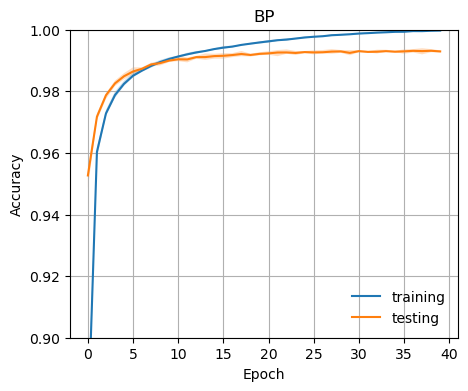

In [5]:

for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(f"BP")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"BP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


### EP conv with weak feedback

In [6]:

num_epochs = 40
multest = 5 #5
fbsc_range = [0] # [0.01, 0.1, 1]
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
# for ilr, lr in enumerate([2.5e-4]):
#     for iwd, wd in enumerate( [2.5e-4]):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc} start at {current_time_tmp}")

        model = aEP_CNN(fbsc=0.01, nudge=0.25, deviden=False, T=20, K=10, chl=[32,64])
        
        
        # optimizer = torch.optim.SGD([
        #     {'params': model.conv1.parameters(), 'lr': 0.05, 'weight_decay': 1e-6},  # conv1 
        #     {'params': model.conv2.parameters(), 'lr': 0.15, 'weight_decay': 1e-6},  # conv2 
        #     {'params': model.fc1.parameters(), 'lr': 0.5, 'weight_decay': 1e-6},  # 
        # ])
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6) # 2.5 ~ 1e-4 0.5e-4
        
        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    # model.bw_symm()
                    preds, loss = model.ep_step(data, target)# eta=[0.015, 0.035, 0.15]
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (preds == target).sum().item()
                    total += target.size(0)
                                    
            # scheduler.step()

            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc}-{imul} end at {current_time_tmp}")
        
res_aEP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_aEP",  **save_dict)
     

0 start at 20250923-152558


Epoch 1/40:: 470batch [00:12, 36.35batch/s, loss=0.688024]                                0.688024]


Epoch 1 Train Loss = 0.6816, Accuracy = 86.97%, Test Accuracy = 94.81%


Epoch 2/40:: 470batch [00:12, 38.98batch/s, loss=0.216661]                                0.216661]


Epoch 2 Train Loss = 0.2158, Accuracy = 95.39%, Test Accuracy = 96.50%


Epoch 3/40:: 470batch [00:12, 38.97batch/s, loss=0.149725]                                0.149725]


Epoch 3 Train Loss = 0.1493, Accuracy = 96.59%, Test Accuracy = 97.18%


Epoch 4/40:: 470batch [00:12, 37.94batch/s, loss=0.120118]                                0.120118]


Epoch 4 Train Loss = 0.1199, Accuracy = 97.16%, Test Accuracy = 97.51%


Epoch 5/40:: 470batch [00:11, 39.24batch/s, loss=0.104499]                                0.104499]


Epoch 5 Train Loss = 0.1046, Accuracy = 97.55%, Test Accuracy = 97.87%


Epoch 6/40:: 470batch [00:12, 38.16batch/s, loss=0.095416]                                0.095416]


Epoch 6 Train Loss = 0.0950, Accuracy = 97.76%, Test Accuracy = 98.02%


Epoch 7/40:: 470batch [00:12, 39.09batch/s, loss=0.086589]                                0.086589]


Epoch 7 Train Loss = 0.0866, Accuracy = 97.95%, Test Accuracy = 98.26%


Epoch 8/40:: 470batch [00:12, 37.87batch/s, loss=0.077448]                                0.077448]


Epoch 8 Train Loss = 0.0774, Accuracy = 98.13%, Test Accuracy = 98.48%


Epoch 9/40:: 470batch [00:12, 37.88batch/s, loss=0.069135]                                0.069135]


Epoch 9 Train Loss = 0.0689, Accuracy = 98.32%, Test Accuracy = 98.44%


Epoch 10/40:: 470batch [00:12, 38.35batch/s, loss=0.063309]                               0.063309]


Epoch 10 Train Loss = 0.0630, Accuracy = 98.44%, Test Accuracy = 98.58%


Epoch 11/40:: 470batch [00:12, 37.86batch/s, loss=0.057904]                               0.057904]


Epoch 11 Train Loss = 0.0578, Accuracy = 98.56%, Test Accuracy = 98.67%


Epoch 12/40:: 470batch [00:12, 38.44batch/s, loss=0.052750]                               0.052750]


Epoch 12 Train Loss = 0.0527, Accuracy = 98.69%, Test Accuracy = 98.76%


Epoch 13/40:: 470batch [00:12, 37.87batch/s, loss=0.048848]                               0.048848]


Epoch 13 Train Loss = 0.0489, Accuracy = 98.77%, Test Accuracy = 98.72%


Epoch 14/40:: 470batch [00:11, 39.21batch/s, loss=0.046420]                               0.046420]


Epoch 14 Train Loss = 0.0463, Accuracy = 98.83%, Test Accuracy = 98.80%


Epoch 15/40:: 470batch [00:12, 39.06batch/s, loss=0.044493]                               0.044493]


Epoch 15 Train Loss = 0.0443, Accuracy = 98.90%, Test Accuracy = 98.78%


Epoch 16/40:: 470batch [00:12, 38.96batch/s, loss=0.042010]                               0.042010]


Epoch 16 Train Loss = 0.0418, Accuracy = 98.93%, Test Accuracy = 98.89%


Epoch 17/40:: 470batch [00:12, 39.10batch/s, loss=0.038135]                               0.038135]


Epoch 17 Train Loss = 0.0381, Accuracy = 99.00%, Test Accuracy = 98.88%


Epoch 18/40:: 470batch [00:12, 38.63batch/s, loss=0.035767]                               0.035767]


Epoch 18 Train Loss = 0.0358, Accuracy = 99.08%, Test Accuracy = 98.97%


Epoch 19/40:: 470batch [00:11, 39.26batch/s, loss=0.033601]                               0.033601]


Epoch 19 Train Loss = 0.0336, Accuracy = 99.11%, Test Accuracy = 99.00%


Epoch 20/40:: 470batch [00:12, 38.12batch/s, loss=0.031446]                               0.031446]


Epoch 20 Train Loss = 0.0315, Accuracy = 99.19%, Test Accuracy = 99.05%


Epoch 21/40:: 470batch [00:11, 39.26batch/s, loss=0.029435]                               0.029435]


Epoch 21 Train Loss = 0.0295, Accuracy = 99.25%, Test Accuracy = 99.03%


Epoch 22/40:: 470batch [00:11, 39.26batch/s, loss=0.028224]                               0.028224]


Epoch 22 Train Loss = 0.0283, Accuracy = 99.30%, Test Accuracy = 99.01%


Epoch 23/40:: 470batch [00:12, 37.76batch/s, loss=0.026990]                               0.026990]


Epoch 23 Train Loss = 0.0269, Accuracy = 99.32%, Test Accuracy = 99.08%


Epoch 24/40:: 470batch [00:12, 38.77batch/s, loss=0.025203]                               0.025203]


Epoch 24 Train Loss = 0.0252, Accuracy = 99.41%, Test Accuracy = 99.07%


Epoch 25/40:: 470batch [00:12, 38.91batch/s, loss=0.023361]                               0.023361]


Epoch 25 Train Loss = 0.0235, Accuracy = 99.44%, Test Accuracy = 99.12%


Epoch 26/40:: 470batch [00:12, 39.07batch/s, loss=0.021005]                               0.021005]


Epoch 26 Train Loss = 0.0214, Accuracy = 99.50%, Test Accuracy = 99.22%


Epoch 27/40:: 470batch [00:12, 38.22batch/s, loss=0.020661]                               0.020661]


Epoch 27 Train Loss = 0.0206, Accuracy = 99.53%, Test Accuracy = 99.13%


Epoch 28/40:: 470batch [00:12, 37.56batch/s, loss=0.020272]                               0.020272]


Epoch 28 Train Loss = 0.0202, Accuracy = 99.53%, Test Accuracy = 99.12%


Epoch 29/40:: 470batch [00:12, 38.75batch/s, loss=0.018712]                               0.018712]


Epoch 29 Train Loss = 0.0189, Accuracy = 99.58%, Test Accuracy = 99.14%


Epoch 30/40:: 470batch [00:12, 38.70batch/s, loss=0.019985]                               0.019985]


Epoch 30 Train Loss = 0.0200, Accuracy = 99.59%, Test Accuracy = 99.17%


Epoch 31/40:: 470batch [00:12, 37.79batch/s, loss=0.023128]                               0.023128]


Epoch 31 Train Loss = 0.0231, Accuracy = 99.49%, Test Accuracy = 99.15%


Epoch 32/40:: 470batch [00:12, 39.02batch/s, loss=0.021819]                               0.021819]


Epoch 32 Train Loss = 0.0219, Accuracy = 99.52%, Test Accuracy = 99.19%


Epoch 33/40:: 470batch [00:13, 34.03batch/s, loss=0.021604]                               0.021604]


Epoch 33 Train Loss = 0.0216, Accuracy = 99.53%, Test Accuracy = 99.16%


Epoch 34/40:: 470batch [00:12, 37.57batch/s, loss=0.020313]                               0.020313]


Epoch 34 Train Loss = 0.0202, Accuracy = 99.55%, Test Accuracy = 99.13%


Epoch 35/40:: 470batch [00:12, 37.43batch/s, loss=0.019341]                               0.019341]


Epoch 35 Train Loss = 0.0193, Accuracy = 99.61%, Test Accuracy = 99.18%


Epoch 36/40:: 470batch [00:11, 39.22batch/s, loss=0.017905]                               0.017905]


Epoch 36 Train Loss = 0.0178, Accuracy = 99.60%, Test Accuracy = 99.20%


Epoch 37/40:: 470batch [00:12, 37.89batch/s, loss=0.016776]                               0.016776]


Epoch 37 Train Loss = 0.0167, Accuracy = 99.63%, Test Accuracy = 99.25%


Epoch 38/40:: 470batch [00:12, 38.66batch/s, loss=0.015950]                               0.015950]


Epoch 38 Train Loss = 0.0159, Accuracy = 99.69%, Test Accuracy = 99.29%


Epoch 39/40:: 470batch [00:12, 37.82batch/s, loss=0.014946]                               0.014946]


Epoch 39 Train Loss = 0.0151, Accuracy = 99.72%, Test Accuracy = 99.00%


Epoch 40/40:: 470batch [00:12, 36.47batch/s, loss=0.014242]                               0.014242]


Epoch 40 Train Loss = 0.0143, Accuracy = 99.75%, Test Accuracy = 99.19%
0-0 end at 20250923-153439
0 start at 20250923-153439


Epoch 1/40:: 470batch [00:13, 35.61batch/s, loss=0.667881]                                0.667881]


Epoch 1 Train Loss = 0.6613, Accuracy = 86.76%, Test Accuracy = 95.20%


Epoch 2/40:: 470batch [00:12, 36.38batch/s, loss=0.216482]                                0.216482]


Epoch 2 Train Loss = 0.2159, Accuracy = 95.51%, Test Accuracy = 96.44%


Epoch 3/40:: 470batch [00:13, 35.38batch/s, loss=0.160906]                                0.160906]


Epoch 3 Train Loss = 0.1610, Accuracy = 96.58%, Test Accuracy = 97.36%


Epoch 4/40:: 470batch [00:13, 34.48batch/s, loss=0.133602]                                0.133602]


Epoch 4 Train Loss = 0.1334, Accuracy = 97.11%, Test Accuracy = 97.58%


Epoch 5/40:: 470batch [00:13, 34.95batch/s, loss=0.114912]                                0.114912]


Epoch 5 Train Loss = 0.1147, Accuracy = 97.48%, Test Accuracy = 97.86%


Epoch 6/40:: 470batch [00:13, 34.06batch/s, loss=0.100822]                                0.100822]


Epoch 6 Train Loss = 0.1008, Accuracy = 97.76%, Test Accuracy = 98.04%


Epoch 7/40:: 470batch [00:12, 36.16batch/s, loss=0.090311]                                0.090311]


Epoch 7 Train Loss = 0.0901, Accuracy = 97.99%, Test Accuracy = 98.21%


Epoch 8/40:: 470batch [00:12, 37.03batch/s, loss=0.079172]                                0.079172]


Epoch 8 Train Loss = 0.0791, Accuracy = 98.18%, Test Accuracy = 98.40%


Epoch 9/40:: 470batch [00:12, 37.18batch/s, loss=0.068626]                                0.068626]


Epoch 9 Train Loss = 0.0683, Accuracy = 98.40%, Test Accuracy = 98.48%


Epoch 10/40:: 470batch [00:12, 37.51batch/s, loss=0.059200]                               0.059200]


Epoch 10 Train Loss = 0.0593, Accuracy = 98.56%, Test Accuracy = 98.66%


Epoch 11/40:: 470batch [00:12, 37.52batch/s, loss=0.051924]                               0.051924]


Epoch 11 Train Loss = 0.0518, Accuracy = 98.71%, Test Accuracy = 98.80%


Epoch 12/40:: 470batch [00:12, 38.97batch/s, loss=0.045624]                               0.045624]


Epoch 12 Train Loss = 0.0457, Accuracy = 98.84%, Test Accuracy = 98.91%


Epoch 13/40:: 470batch [00:12, 36.91batch/s, loss=0.040782]                               0.040782]


Epoch 13 Train Loss = 0.0408, Accuracy = 98.97%, Test Accuracy = 98.94%


Epoch 14/40:: 470batch [00:12, 37.07batch/s, loss=0.036770]                               0.036770]


Epoch 14 Train Loss = 0.0369, Accuracy = 99.07%, Test Accuracy = 99.06%


Epoch 15/40:: 470batch [00:12, 38.08batch/s, loss=0.033601]                               0.033601]


Epoch 15 Train Loss = 0.0337, Accuracy = 99.15%, Test Accuracy = 99.15%


Epoch 16/40:: 470batch [00:12, 36.71batch/s, loss=0.030470]                               0.030470]


Epoch 16 Train Loss = 0.0304, Accuracy = 99.22%, Test Accuracy = 99.15%


Epoch 17/40:: 470batch [00:12, 38.50batch/s, loss=0.027866]                               0.027866]


Epoch 17 Train Loss = 0.0279, Accuracy = 99.30%, Test Accuracy = 99.21%


Epoch 18/40:: 470batch [00:12, 37.62batch/s, loss=0.025717]                               0.025717]


Epoch 18 Train Loss = 0.0256, Accuracy = 99.34%, Test Accuracy = 99.19%


Epoch 19/40:: 470batch [00:12, 37.85batch/s, loss=0.023372]                               0.023372]


Epoch 19 Train Loss = 0.0234, Accuracy = 99.43%, Test Accuracy = 99.23%


Epoch 20/40:: 470batch [00:13, 36.14batch/s, loss=0.022126]                               0.022126]


Epoch 20 Train Loss = 0.0221, Accuracy = 99.47%, Test Accuracy = 99.22%


Epoch 21/40:: 470batch [00:12, 36.88batch/s, loss=0.020985]                               0.020985]


Epoch 21 Train Loss = 0.0210, Accuracy = 99.51%, Test Accuracy = 99.27%


Epoch 22/40:: 470batch [00:12, 36.81batch/s, loss=0.019696]                               0.019696]


Epoch 22 Train Loss = 0.0198, Accuracy = 99.55%, Test Accuracy = 99.23%


Epoch 23/40:: 470batch [00:12, 37.55batch/s, loss=0.018276]                               0.018276]


Epoch 23 Train Loss = 0.0183, Accuracy = 99.61%, Test Accuracy = 99.32%


Epoch 24/40:: 470batch [00:12, 36.58batch/s, loss=0.016923]                               0.016923]


Epoch 24 Train Loss = 0.0168, Accuracy = 99.63%, Test Accuracy = 99.31%


Epoch 25/40:: 470batch [00:12, 37.36batch/s, loss=0.015492]                               0.015492]


Epoch 25 Train Loss = 0.0155, Accuracy = 99.68%, Test Accuracy = 99.24%


Epoch 26/40:: 470batch [00:14, 33.54batch/s, loss=0.013956]                               0.013956]


Epoch 26 Train Loss = 0.0140, Accuracy = 99.73%, Test Accuracy = 99.31%


Epoch 27/40:: 470batch [00:13, 35.25batch/s, loss=0.012717]                               0.012717]


Epoch 27 Train Loss = 0.0128, Accuracy = 99.75%, Test Accuracy = 99.28%


Epoch 28/40:: 470batch [00:12, 37.12batch/s, loss=0.011520]                               0.011520]


Epoch 28 Train Loss = 0.0115, Accuracy = 99.81%, Test Accuracy = 99.29%


Epoch 29/40:: 470batch [00:12, 37.20batch/s, loss=0.010534]                               0.010534]


Epoch 29 Train Loss = 0.0106, Accuracy = 99.81%, Test Accuracy = 99.27%


Epoch 30/40:: 470batch [00:12, 37.92batch/s, loss=0.009619]                               0.009619]


Epoch 30 Train Loss = 0.0097, Accuracy = 99.85%, Test Accuracy = 99.32%


Epoch 31/40:: 470batch [00:12, 37.94batch/s, loss=0.008664]                               0.008664]


Epoch 31 Train Loss = 0.0086, Accuracy = 99.87%, Test Accuracy = 99.38%


Epoch 32/40:: 470batch [00:12, 38.64batch/s, loss=0.007974]                               0.007974]


Epoch 32 Train Loss = 0.0080, Accuracy = 99.88%, Test Accuracy = 99.30%


Epoch 33/40:: 470batch [00:12, 37.68batch/s, loss=0.007205]                               0.007205]


Epoch 33 Train Loss = 0.0072, Accuracy = 99.91%, Test Accuracy = 99.34%


Epoch 34/40:: 470batch [00:12, 37.26batch/s, loss=0.006673]                               0.006673]


Epoch 34 Train Loss = 0.0067, Accuracy = 99.91%, Test Accuracy = 99.32%


Epoch 35/40:: 470batch [00:12, 37.84batch/s, loss=0.006064]                               0.006064]


Epoch 35 Train Loss = 0.0061, Accuracy = 99.94%, Test Accuracy = 99.34%


Epoch 36/40:: 470batch [00:12, 37.48batch/s, loss=0.006105]                               0.006105]


Epoch 36 Train Loss = 0.0061, Accuracy = 99.94%, Test Accuracy = 99.32%


Epoch 37/40:: 470batch [00:12, 38.40batch/s, loss=0.006347]                               0.006347]


Epoch 37 Train Loss = 0.0064, Accuracy = 99.94%, Test Accuracy = 99.37%


Epoch 38/40:: 470batch [00:12, 37.72batch/s, loss=0.006616]                               0.006616]


Epoch 38 Train Loss = 0.0066, Accuracy = 99.94%, Test Accuracy = 99.30%


Epoch 39/40:: 470batch [00:12, 36.79batch/s, loss=0.007912]                               0.007912]


Epoch 39 Train Loss = 0.0079, Accuracy = 99.93%, Test Accuracy = 99.34%


Epoch 40/40:: 470batch [00:12, 37.53batch/s, loss=0.008243]                               0.008243]


Epoch 40 Train Loss = 0.0082, Accuracy = 99.91%, Test Accuracy = 99.28%
0-1 end at 20250923-154338
0 start at 20250923-154338


Epoch 1/40:: 470batch [00:12, 37.53batch/s, loss=0.692546]                                0.692546]


Epoch 1 Train Loss = 0.6858, Accuracy = 86.65%, Test Accuracy = 95.02%


Epoch 2/40:: 470batch [00:12, 37.24batch/s, loss=0.220229]                                0.220229]


Epoch 2 Train Loss = 0.2195, Accuracy = 95.43%, Test Accuracy = 96.43%


Epoch 3/40:: 470batch [00:12, 38.41batch/s, loss=0.158637]                                0.158637]


Epoch 3 Train Loss = 0.1583, Accuracy = 96.54%, Test Accuracy = 97.02%


Epoch 4/40:: 470batch [00:12, 37.66batch/s, loss=0.126382]                                0.126382]


Epoch 4 Train Loss = 0.1262, Accuracy = 97.14%, Test Accuracy = 97.61%


Epoch 5/40:: 470batch [00:12, 37.56batch/s, loss=0.106107]                                0.106107]


Epoch 5 Train Loss = 0.1062, Accuracy = 97.55%, Test Accuracy = 97.84%


Epoch 6/40:: 470batch [00:12, 37.39batch/s, loss=0.092895]                                0.092895]


Epoch 6 Train Loss = 0.0928, Accuracy = 97.81%, Test Accuracy = 98.09%


Epoch 7/40:: 470batch [00:12, 37.75batch/s, loss=0.081964]                                0.081964]


Epoch 7 Train Loss = 0.0816, Accuracy = 98.04%, Test Accuracy = 98.34%


Epoch 8/40:: 470batch [00:12, 37.79batch/s, loss=0.071223]                                0.071223]


Epoch 8 Train Loss = 0.0709, Accuracy = 98.26%, Test Accuracy = 98.49%


Epoch 9/40:: 470batch [00:12, 37.01batch/s, loss=0.060430]                                0.060430]


Epoch 9 Train Loss = 0.0606, Accuracy = 98.41%, Test Accuracy = 98.59%


Epoch 10/40:: 470batch [00:12, 38.10batch/s, loss=0.054409]                               0.054409]


Epoch 10 Train Loss = 0.0543, Accuracy = 98.63%, Test Accuracy = 98.75%


Epoch 11/40:: 470batch [00:12, 36.94batch/s, loss=0.048985]                               0.048985]


Epoch 11 Train Loss = 0.0495, Accuracy = 98.76%, Test Accuracy = 98.79%


Epoch 12/40:: 470batch [00:12, 38.00batch/s, loss=0.046015]                               0.046015]


Epoch 12 Train Loss = 0.0460, Accuracy = 98.85%, Test Accuracy = 98.84%


Epoch 13/40:: 470batch [00:12, 38.26batch/s, loss=0.043296]                               0.043296]


Epoch 13 Train Loss = 0.0431, Accuracy = 98.93%, Test Accuracy = 98.87%


Epoch 14/40:: 470batch [00:12, 38.06batch/s, loss=0.039921]                               0.039921]


Epoch 14 Train Loss = 0.0399, Accuracy = 99.00%, Test Accuracy = 98.90%


Epoch 15/40:: 470batch [00:12, 37.45batch/s, loss=0.036391]                               0.036391]


Epoch 15 Train Loss = 0.0364, Accuracy = 99.05%, Test Accuracy = 98.90%


Epoch 16/40:: 470batch [00:12, 38.40batch/s, loss=0.033775]                               0.033775]


Epoch 16 Train Loss = 0.0338, Accuracy = 99.11%, Test Accuracy = 98.95%


Epoch 17/40:: 470batch [00:12, 38.51batch/s, loss=0.030998]                               0.030998]


Epoch 17 Train Loss = 0.0310, Accuracy = 99.20%, Test Accuracy = 99.05%


Epoch 18/40:: 470batch [00:12, 38.22batch/s, loss=0.029104]                               0.029104]


Epoch 18 Train Loss = 0.0291, Accuracy = 99.29%, Test Accuracy = 99.06%


Epoch 19/40:: 470batch [00:12, 37.63batch/s, loss=0.026721]                               0.026721]


Epoch 19 Train Loss = 0.0266, Accuracy = 99.30%, Test Accuracy = 99.05%


Epoch 20/40:: 470batch [00:12, 37.41batch/s, loss=0.024918]                               0.024918]


Epoch 20 Train Loss = 0.0248, Accuracy = 99.33%, Test Accuracy = 99.09%


Epoch 21/40:: 470batch [00:12, 37.29batch/s, loss=0.022807]                               0.022807]


Epoch 21 Train Loss = 0.0228, Accuracy = 99.43%, Test Accuracy = 99.09%


Epoch 22/40:: 470batch [00:12, 37.12batch/s, loss=0.021582]                               0.021582]


Epoch 22 Train Loss = 0.0217, Accuracy = 99.45%, Test Accuracy = 99.08%


Epoch 23/40:: 470batch [00:12, 37.53batch/s, loss=0.020651]                               0.020651]


Epoch 23 Train Loss = 0.0207, Accuracy = 99.52%, Test Accuracy = 99.08%


Epoch 24/40:: 470batch [00:12, 37.59batch/s, loss=0.019477]                               0.019477]


Epoch 24 Train Loss = 0.0196, Accuracy = 99.54%, Test Accuracy = 99.14%


Epoch 25/40:: 470batch [00:12, 37.14batch/s, loss=0.018744]                               0.018744]


Epoch 25 Train Loss = 0.0186, Accuracy = 99.58%, Test Accuracy = 99.14%


Epoch 26/40:: 470batch [00:12, 37.62batch/s, loss=0.017781]                               0.017781]


Epoch 26 Train Loss = 0.0178, Accuracy = 99.61%, Test Accuracy = 99.11%


Epoch 27/40:: 470batch [00:12, 38.16batch/s, loss=0.017288]                               0.017288]


Epoch 27 Train Loss = 0.0173, Accuracy = 99.64%, Test Accuracy = 99.08%


Epoch 28/40:: 470batch [00:12, 37.16batch/s, loss=0.015860]                               0.015860]


Epoch 28 Train Loss = 0.0160, Accuracy = 99.66%, Test Accuracy = 99.15%


Epoch 29/40:: 470batch [00:12, 37.92batch/s, loss=0.014990]                               0.014990]


Epoch 29 Train Loss = 0.0150, Accuracy = 99.69%, Test Accuracy = 99.19%


Epoch 30/40:: 470batch [00:12, 38.32batch/s, loss=0.014228]                               0.014228]


Epoch 30 Train Loss = 0.0143, Accuracy = 99.70%, Test Accuracy = 99.17%


Epoch 31/40:: 470batch [00:12, 37.01batch/s, loss=0.014719]                               0.014719]


Epoch 31 Train Loss = 0.0147, Accuracy = 99.68%, Test Accuracy = 99.11%


Epoch 32/40:: 470batch [00:12, 38.18batch/s, loss=0.016115]                               0.016115]


Epoch 32 Train Loss = 0.0161, Accuracy = 99.65%, Test Accuracy = 99.00%


Epoch 33/40:: 470batch [00:12, 38.24batch/s, loss=0.014475]                               0.014475]


Epoch 33 Train Loss = 0.0147, Accuracy = 99.71%, Test Accuracy = 99.19%


Epoch 34/40:: 470batch [00:12, 37.87batch/s, loss=0.015579]                               0.015579]


Epoch 34 Train Loss = 0.0156, Accuracy = 99.71%, Test Accuracy = 99.11%


Epoch 35/40:: 470batch [00:12, 36.51batch/s, loss=0.015859]                               0.015859]


Epoch 35 Train Loss = 0.0158, Accuracy = 99.66%, Test Accuracy = 99.13%


Epoch 36/40:: 470batch [00:12, 36.66batch/s, loss=0.016008]                               0.016008]


Epoch 36 Train Loss = 0.0160, Accuracy = 99.66%, Test Accuracy = 99.15%


Epoch 37/40:: 470batch [00:12, 36.93batch/s, loss=0.017325]                               0.017325]


Epoch 37 Train Loss = 0.0175, Accuracy = 99.64%, Test Accuracy = 99.08%


Epoch 38/40:: 470batch [00:12, 37.86batch/s, loss=0.019093]                               0.019093]


Epoch 38 Train Loss = 0.0191, Accuracy = 99.61%, Test Accuracy = 99.17%


Epoch 39/40:: 470batch [00:12, 37.33batch/s, loss=0.018395]                               0.018395]


Epoch 39 Train Loss = 0.0184, Accuracy = 99.60%, Test Accuracy = 99.14%


Epoch 40/40:: 470batch [00:12, 37.24batch/s, loss=0.017443]                               0.017443]


Epoch 40 Train Loss = 0.0175, Accuracy = 99.64%, Test Accuracy = 99.06%
0-2 end at 20250923-155227
0 start at 20250923-155227


Epoch 1/40:: 470batch [00:12, 37.75batch/s, loss=0.709382]                                0.709382]


Epoch 1 Train Loss = 0.7018, Accuracy = 85.31%, Test Accuracy = 94.22%


Epoch 2/40:: 470batch [00:12, 37.78batch/s, loss=0.230610]                                0.230610]


Epoch 2 Train Loss = 0.2297, Accuracy = 95.12%, Test Accuracy = 96.28%


Epoch 3/40:: 470batch [00:12, 36.88batch/s, loss=0.159267]                                0.159267]


Epoch 3 Train Loss = 0.1585, Accuracy = 96.41%, Test Accuracy = 97.03%


Epoch 4/40:: 470batch [00:12, 37.42batch/s, loss=0.123641]                                0.123641]


Epoch 4 Train Loss = 0.1237, Accuracy = 97.03%, Test Accuracy = 97.60%


Epoch 5/40:: 470batch [00:13, 34.87batch/s, loss=0.103112]                                0.103112]


Epoch 5 Train Loss = 0.1029, Accuracy = 97.51%, Test Accuracy = 97.86%


Epoch 6/40:: 470batch [00:13, 34.22batch/s, loss=0.088032]                                0.088032]


Epoch 6 Train Loss = 0.0880, Accuracy = 97.89%, Test Accuracy = 98.12%


Epoch 7/40:: 470batch [00:13, 35.21batch/s, loss=0.077630]                                0.077630]


Epoch 7 Train Loss = 0.0773, Accuracy = 98.07%, Test Accuracy = 98.23%


Epoch 8/40:: 470batch [00:13, 35.74batch/s, loss=0.068348]                                0.068348]


Epoch 8 Train Loss = 0.0683, Accuracy = 98.27%, Test Accuracy = 98.33%


Epoch 9/40:: 470batch [00:13, 34.47batch/s, loss=0.061687]                                0.061687]


Epoch 9 Train Loss = 0.0614, Accuracy = 98.45%, Test Accuracy = 98.62%


Epoch 10/40:: 470batch [00:13, 34.63batch/s, loss=0.055003]                               0.055003]


Epoch 10 Train Loss = 0.0549, Accuracy = 98.60%, Test Accuracy = 98.60%


Epoch 11/40:: 470batch [00:13, 35.88batch/s, loss=0.050597]                               0.050597]


Epoch 11 Train Loss = 0.0507, Accuracy = 98.71%, Test Accuracy = 98.70%


Epoch 12/40:: 470batch [00:13, 34.30batch/s, loss=0.047232]                               0.047232]


Epoch 12 Train Loss = 0.0472, Accuracy = 98.78%, Test Accuracy = 98.77%


Epoch 13/40:: 470batch [00:13, 35.38batch/s, loss=0.043774]                               0.043774]


Epoch 13 Train Loss = 0.0438, Accuracy = 98.89%, Test Accuracy = 98.81%


Epoch 14/40:: 470batch [00:13, 34.64batch/s, loss=0.040756]                               0.040756]


Epoch 14 Train Loss = 0.0408, Accuracy = 98.94%, Test Accuracy = 98.79%


Epoch 15/40:: 470batch [00:13, 34.12batch/s, loss=0.038231]                               0.038231]


Epoch 15 Train Loss = 0.0380, Accuracy = 99.00%, Test Accuracy = 98.98%


Epoch 16/40:: 470batch [00:13, 35.73batch/s, loss=0.034786]                               0.034786]


Epoch 16 Train Loss = 0.0349, Accuracy = 99.05%, Test Accuracy = 98.94%


Epoch 17/40:: 470batch [00:13, 35.22batch/s, loss=0.032494]                               0.032494]


Epoch 17 Train Loss = 0.0324, Accuracy = 99.12%, Test Accuracy = 98.97%


Epoch 18/40:: 470batch [00:13, 35.33batch/s, loss=0.030249]                               0.030249]


Epoch 18 Train Loss = 0.0302, Accuracy = 99.16%, Test Accuracy = 99.14%


Epoch 19/40:: 470batch [00:13, 35.20batch/s, loss=0.028712]                               0.028712]


Epoch 19 Train Loss = 0.0285, Accuracy = 99.22%, Test Accuracy = 99.06%


Epoch 20/40:: 470batch [00:13, 34.85batch/s, loss=0.027163]                               0.027163]


Epoch 20 Train Loss = 0.0271, Accuracy = 99.31%, Test Accuracy = 99.08%


Epoch 21/40:: 470batch [00:13, 35.12batch/s, loss=0.026036]                               0.026036]


Epoch 21 Train Loss = 0.0260, Accuracy = 99.30%, Test Accuracy = 99.15%


Epoch 22/40:: 470batch [00:12, 37.59batch/s, loss=0.025316]                               0.025316]


Epoch 22 Train Loss = 0.0252, Accuracy = 99.35%, Test Accuracy = 99.16%


Epoch 23/40:: 470batch [00:12, 36.69batch/s, loss=0.024178]                               0.024178]


Epoch 23 Train Loss = 0.0243, Accuracy = 99.41%, Test Accuracy = 99.09%


Epoch 24/40:: 470batch [00:12, 37.47batch/s, loss=0.024206]                               0.024206]


Epoch 24 Train Loss = 0.0243, Accuracy = 99.39%, Test Accuracy = 99.18%


Epoch 25/40:: 470batch [00:12, 37.09batch/s, loss=0.025177]                               0.025177]


Epoch 25 Train Loss = 0.0252, Accuracy = 99.40%, Test Accuracy = 98.98%


Epoch 26/40:: 470batch [00:12, 36.77batch/s, loss=0.025657]                               0.025657]


Epoch 26 Train Loss = 0.0256, Accuracy = 99.36%, Test Accuracy = 99.07%


Epoch 27/40:: 470batch [00:12, 37.95batch/s, loss=0.025178]                               0.025178]


Epoch 27 Train Loss = 0.0253, Accuracy = 99.39%, Test Accuracy = 99.07%


Epoch 28/40:: 470batch [00:12, 36.98batch/s, loss=0.026998]                               0.026998]


Epoch 28 Train Loss = 0.0270, Accuracy = 99.36%, Test Accuracy = 99.14%


Epoch 29/40:: 470batch [00:12, 36.95batch/s, loss=0.026793]                               0.026793]


Epoch 29 Train Loss = 0.0269, Accuracy = 99.39%, Test Accuracy = 99.08%


Epoch 30/40:: 470batch [00:12, 37.88batch/s, loss=0.028728]                               0.028728]


Epoch 30 Train Loss = 0.0288, Accuracy = 99.40%, Test Accuracy = 99.03%


Epoch 31/40:: 470batch [00:12, 37.26batch/s, loss=0.030250]                               0.030250]


Epoch 31 Train Loss = 0.0301, Accuracy = 99.37%, Test Accuracy = 99.02%


Epoch 32/40:: 470batch [00:12, 36.78batch/s, loss=0.028708]                               0.028708]


Epoch 32 Train Loss = 0.0287, Accuracy = 99.40%, Test Accuracy = 99.05%


Epoch 33/40:: 470batch [00:12, 36.16batch/s, loss=0.027533]                               0.027533]


Epoch 33 Train Loss = 0.0275, Accuracy = 99.41%, Test Accuracy = 99.17%


Epoch 34/40:: 470batch [00:12, 36.76batch/s, loss=0.025718]                               0.025718]


Epoch 34 Train Loss = 0.0257, Accuracy = 99.47%, Test Accuracy = 99.15%


Epoch 35/40:: 470batch [00:12, 38.34batch/s, loss=0.025010]                               0.025010]


Epoch 35 Train Loss = 0.0251, Accuracy = 99.46%, Test Accuracy = 99.13%


Epoch 36/40:: 470batch [00:12, 36.89batch/s, loss=0.021961]                               0.021961]


Epoch 36 Train Loss = 0.0220, Accuracy = 99.45%, Test Accuracy = 99.06%


Epoch 37/40:: 470batch [00:12, 36.67batch/s, loss=0.019118]                               0.019118]


Epoch 37 Train Loss = 0.0190, Accuracy = 99.52%, Test Accuracy = 99.16%


Epoch 38/40:: 470batch [00:12, 37.89batch/s, loss=0.016839]                               0.016839]


Epoch 38 Train Loss = 0.0167, Accuracy = 99.60%, Test Accuracy = 99.10%


Epoch 39/40:: 470batch [00:12, 37.45batch/s, loss=0.015629]                               0.015629]


Epoch 39 Train Loss = 0.0156, Accuracy = 99.64%, Test Accuracy = 99.16%


Epoch 40/40:: 470batch [00:12, 37.12batch/s, loss=0.014545]                               0.014545]


Epoch 40 Train Loss = 0.0144, Accuracy = 99.71%, Test Accuracy = 99.24%
0-3 end at 20250923-160135
0 start at 20250923-160135


Epoch 1/40:: 470batch [00:12, 37.95batch/s, loss=0.690663]                                0.690663]


Epoch 1 Train Loss = 0.6839, Accuracy = 86.26%, Test Accuracy = 94.44%


Epoch 2/40:: 470batch [00:12, 37.82batch/s, loss=0.234225]                                0.234225]


Epoch 2 Train Loss = 0.2336, Accuracy = 94.98%, Test Accuracy = 96.22%


Epoch 3/40:: 470batch [00:12, 37.57batch/s, loss=0.166542]                                0.166542]


Epoch 3 Train Loss = 0.1664, Accuracy = 96.26%, Test Accuracy = 97.02%


Epoch 4/40:: 470batch [00:12, 37.58batch/s, loss=0.131238]                                0.131238]


Epoch 4 Train Loss = 0.1314, Accuracy = 96.91%, Test Accuracy = 97.50%


Epoch 5/40:: 470batch [00:12, 38.06batch/s, loss=0.108747]                                0.108747]


Epoch 5 Train Loss = 0.1087, Accuracy = 97.37%, Test Accuracy = 97.77%


Epoch 6/40:: 470batch [00:12, 37.74batch/s, loss=0.088982]                                0.088982]


Epoch 6 Train Loss = 0.0888, Accuracy = 97.77%, Test Accuracy = 98.08%


Epoch 7/40:: 470batch [00:12, 37.13batch/s, loss=0.077990]                                0.077990]


Epoch 7 Train Loss = 0.0778, Accuracy = 98.10%, Test Accuracy = 98.22%


Epoch 8/40:: 470batch [00:12, 37.53batch/s, loss=0.069565]                                0.069565]


Epoch 8 Train Loss = 0.0694, Accuracy = 98.28%, Test Accuracy = 98.29%


Epoch 9/40:: 470batch [00:12, 36.73batch/s, loss=0.063178]                                0.063178]


Epoch 9 Train Loss = 0.0629, Accuracy = 98.46%, Test Accuracy = 98.51%


Epoch 10/40:: 470batch [00:12, 38.86batch/s, loss=0.057366]                               0.057366]


Epoch 10 Train Loss = 0.0574, Accuracy = 98.56%, Test Accuracy = 98.55%


Epoch 11/40:: 470batch [00:12, 37.36batch/s, loss=0.052624]                               0.052624]


Epoch 11 Train Loss = 0.0528, Accuracy = 98.68%, Test Accuracy = 98.70%


Epoch 12/40:: 470batch [00:12, 37.38batch/s, loss=0.048145]                               0.048145]


Epoch 12 Train Loss = 0.0481, Accuracy = 98.77%, Test Accuracy = 98.72%


Epoch 13/40:: 470batch [00:12, 38.28batch/s, loss=0.044129]                               0.044129]


Epoch 13 Train Loss = 0.0440, Accuracy = 98.86%, Test Accuracy = 98.92%


Epoch 14/40:: 470batch [00:12, 37.30batch/s, loss=0.040506]                               0.040506]


Epoch 14 Train Loss = 0.0404, Accuracy = 98.95%, Test Accuracy = 98.93%


Epoch 15/40:: 470batch [00:12, 38.15batch/s, loss=0.036915]                               0.036915]


Epoch 15 Train Loss = 0.0368, Accuracy = 99.06%, Test Accuracy = 98.91%


Epoch 16/40:: 470batch [00:12, 37.06batch/s, loss=0.034359]                               0.034359]


Epoch 16 Train Loss = 0.0343, Accuracy = 99.10%, Test Accuracy = 98.96%


Epoch 17/40:: 470batch [00:12, 37.54batch/s, loss=0.032507]                               0.032507]


Epoch 17 Train Loss = 0.0326, Accuracy = 99.16%, Test Accuracy = 98.91%


Epoch 18/40:: 470batch [00:12, 37.73batch/s, loss=0.030606]                               0.030606]


Epoch 18 Train Loss = 0.0306, Accuracy = 99.23%, Test Accuracy = 98.99%


Epoch 19/40:: 470batch [00:12, 37.96batch/s, loss=0.027519]                               0.027519]


Epoch 19 Train Loss = 0.0277, Accuracy = 99.31%, Test Accuracy = 99.05%


Epoch 20/40:: 470batch [00:12, 37.77batch/s, loss=0.025627]                               0.025627]


Epoch 20 Train Loss = 0.0257, Accuracy = 99.36%, Test Accuracy = 99.16%


Epoch 21/40:: 470batch [00:12, 37.86batch/s, loss=0.023957]                               0.023957]


Epoch 21 Train Loss = 0.0238, Accuracy = 99.42%, Test Accuracy = 99.15%


Epoch 22/40:: 470batch [00:12, 36.52batch/s, loss=0.022546]                               0.022546]


Epoch 22 Train Loss = 0.0225, Accuracy = 99.44%, Test Accuracy = 99.09%


Epoch 23/40:: 470batch [00:12, 36.17batch/s, loss=0.021077]                               0.021077]


Epoch 23 Train Loss = 0.0210, Accuracy = 99.51%, Test Accuracy = 99.17%


Epoch 24/40:: 470batch [00:12, 37.23batch/s, loss=0.019041]                               0.019041]


Epoch 24 Train Loss = 0.0191, Accuracy = 99.58%, Test Accuracy = 99.15%


Epoch 25/40:: 470batch [00:12, 37.41batch/s, loss=0.017764]                               0.017764]


Epoch 25 Train Loss = 0.0178, Accuracy = 99.61%, Test Accuracy = 99.19%


Epoch 26/40:: 470batch [00:12, 36.84batch/s, loss=0.016581]                               0.016581]


Epoch 26 Train Loss = 0.0166, Accuracy = 99.65%, Test Accuracy = 99.22%


Epoch 27/40:: 470batch [00:12, 37.21batch/s, loss=0.015653]                               0.015653]


Epoch 27 Train Loss = 0.0157, Accuracy = 99.69%, Test Accuracy = 99.20%


Epoch 28/40:: 470batch [00:12, 36.87batch/s, loss=0.014924]                               0.014924]


Epoch 28 Train Loss = 0.0149, Accuracy = 99.72%, Test Accuracy = 99.16%


Epoch 29/40:: 470batch [00:12, 36.70batch/s, loss=0.014771]                               0.014771]


Epoch 29 Train Loss = 0.0147, Accuracy = 99.73%, Test Accuracy = 99.14%


Epoch 30/40:: 470batch [00:12, 36.26batch/s, loss=0.014327]                               0.014327]


Epoch 30 Train Loss = 0.0144, Accuracy = 99.75%, Test Accuracy = 99.19%


Epoch 31/40:: 470batch [00:12, 37.22batch/s, loss=0.013627]                               0.013627]


Epoch 31 Train Loss = 0.0138, Accuracy = 99.76%, Test Accuracy = 99.25%


Epoch 32/40:: 470batch [00:12, 38.48batch/s, loss=0.014012]                               0.014012]


Epoch 32 Train Loss = 0.0140, Accuracy = 99.74%, Test Accuracy = 99.23%


Epoch 33/40:: 470batch [00:12, 37.74batch/s, loss=0.015077]                               0.015077]


Epoch 33 Train Loss = 0.0152, Accuracy = 99.72%, Test Accuracy = 99.18%


Epoch 34/40:: 470batch [00:12, 38.34batch/s, loss=0.023889]                               0.023889]


Epoch 34 Train Loss = 0.0241, Accuracy = 99.62%, Test Accuracy = 98.88%


Epoch 35/40:: 470batch [00:12, 38.04batch/s, loss=0.029610]                               0.029610]


Epoch 35 Train Loss = 0.0297, Accuracy = 99.48%, Test Accuracy = 99.04%


Epoch 36/40:: 470batch [00:12, 38.13batch/s, loss=0.027968]                               0.027968]


Epoch 36 Train Loss = 0.0280, Accuracy = 99.47%, Test Accuracy = 99.04%


Epoch 37/40:: 470batch [00:12, 37.83batch/s, loss=0.025187]                               0.025187]


Epoch 37 Train Loss = 0.0253, Accuracy = 99.53%, Test Accuracy = 99.17%


Epoch 38/40:: 470batch [00:12, 37.21batch/s, loss=0.023923]                               0.023923]


Epoch 38 Train Loss = 0.0238, Accuracy = 99.58%, Test Accuracy = 99.16%


Epoch 39/40:: 470batch [00:12, 36.95batch/s, loss=0.022459]                               0.022459]


Epoch 39 Train Loss = 0.0226, Accuracy = 99.61%, Test Accuracy = 99.23%


Epoch 40/40:: 470batch [00:12, 37.22batch/s, loss=0.021374]                               0.021374]


Epoch 40 Train Loss = 0.0214, Accuracy = 99.65%, Test Accuracy = 99.15%
0-4 end at 20250923-161026


	_train: 99.78%+-0.10% (99.71% 99.94%)	 test: 99.27%+-0.07% (99.19% 99.38%)

Current Time: 20250923-161026


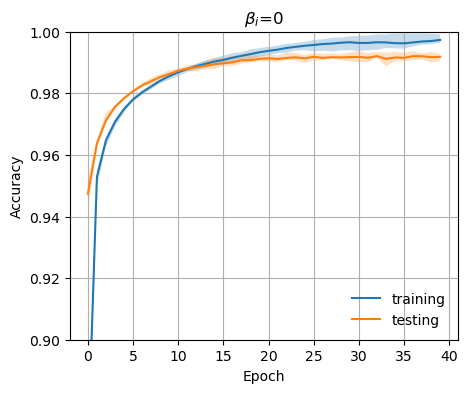

In [7]:

for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"aEP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


### EP conv without weak feedback

In [8]:

num_epochs = 40
multest = 1 #5
fbsc_range = [0] # 0.01, 0.1, 1
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
# for ilr, lr in enumerate([2.5e-4]):
#     for iwd, wd in enumerate( [2.5e-4]):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc} start at {current_time_tmp}")

        model = aEP_CNN(fbsc=1,  nudge=0.25, deviden=False, T=200, K=10, chl=[32,64])
        
        
        # optimizer = torch.optim.SGD([
        #     {'params': model.conv1.parameters(), 'lr': 0.01, 'weight_decay': 0e-6},  # conv1 
        #     {'params': model.conv2.parameters(), 'lr': 0.03, 'weight_decay': 0e-6},  # conv2 
        #     {'params': model.fc1.parameters(), 'lr': 0.1, 'weight_decay': 0e-6},  # 
        # ])
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0e-5) # 2.5 ~ 1e-4 0.5e-4

        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    # model.bw_symm()
                    preds, loss = model.ep_step(data, target)# eta=[0.015, 0.035, 0.15]
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 10 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(10)

                    correct += (preds == target).sum().item()
                    total += target.size(0)
                        
            # scheduler.step()
            
            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{ifbsc}-{imul} end at {current_time_tmp}")
        
res_EP = res
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res_EP",  **save_dict)


0 start at 20250923-161027


Epoch 1/40:: 470batch [01:16,  6.12batch/s, loss=1.359240]                                1.359240]


Epoch 1 Train Loss = 1.3474, Accuracy = 76.27%, Test Accuracy = 88.17%


Epoch 2/40:: 470batch [01:18,  6.03batch/s, loss=0.513059]                                0.513059]


Epoch 2 Train Loss = 0.5129, Accuracy = 88.98%, Test Accuracy = 89.60%


Epoch 3/40:: 470batch [01:16,  6.18batch/s, loss=0.422064]                                0.422064]


Epoch 3 Train Loss = 0.4225, Accuracy = 90.11%, Test Accuracy = 90.80%


Epoch 4/40:: 470batch [01:15,  6.26batch/s, loss=0.465506]                                0.465506]


Epoch 4 Train Loss = 0.4669, Accuracy = 89.39%, Test Accuracy = 90.03%


Epoch 5/40:: 470batch [01:16,  6.18batch/s, loss=0.483961]                                0.483961]


Epoch 5 Train Loss = 0.4840, Accuracy = 89.34%, Test Accuracy = 90.92%


Epoch 6/40:: 470batch [01:14,  6.33batch/s, loss=0.415523]                                0.415523]


Epoch 6 Train Loss = 0.4146, Accuracy = 90.25%, Test Accuracy = 91.56%


Epoch 7/40:: 470batch [01:14,  6.30batch/s, loss=0.388139]                                0.388139]


Epoch 7 Train Loss = 0.3885, Accuracy = 90.90%, Test Accuracy = 90.61%


Epoch 8/40:: 470batch [01:16,  6.14batch/s, loss=0.428776]                                0.428776]


Epoch 8 Train Loss = 0.4290, Accuracy = 89.19%, Test Accuracy = 90.12%


Epoch 9/40:: 470batch [01:16,  6.15batch/s, loss=0.404991]                                0.404991]


Epoch 9 Train Loss = 0.4049, Accuracy = 90.05%, Test Accuracy = 91.81%


Epoch 10/40:: 470batch [01:16,  6.11batch/s, loss=0.434293]                               0.434293]


Epoch 10 Train Loss = 0.4332, Accuracy = 90.11%, Test Accuracy = 91.25%


Epoch 11/40:: 470batch [01:16,  6.15batch/s, loss=0.353360]                               0.353360]


Epoch 11 Train Loss = 0.3529, Accuracy = 91.46%, Test Accuracy = 93.21%


Epoch 12/40:: 470batch [01:35,  4.90batch/s, loss=0.310045]                               0.310045]


Epoch 12 Train Loss = 0.3095, Accuracy = 92.04%, Test Accuracy = 93.24%


Epoch 13/40:: 470batch [01:38,  4.75batch/s, loss=0.255336]                               0.255336]


Epoch 13 Train Loss = 0.2547, Accuracy = 93.02%, Test Accuracy = 94.26%


Epoch 14/40:: 470batch [01:40,  4.68batch/s, loss=0.281694]                               0.281694]


Epoch 14 Train Loss = 0.2841, Accuracy = 92.55%, Test Accuracy = 92.06%


Epoch 15/40:: 470batch [01:37,  4.83batch/s, loss=0.332372]                               0.332372]


Epoch 15 Train Loss = 0.3311, Accuracy = 92.22%, Test Accuracy = 93.68%


Epoch 16/40:: 470batch [01:29,  5.27batch/s, loss=0.268725]                               0.268725]


Epoch 16 Train Loss = 0.2684, Accuracy = 93.17%, Test Accuracy = 93.77%


Epoch 17/40:: 470batch [01:14,  6.31batch/s, loss=0.273655]                               0.273655]


Epoch 17 Train Loss = 0.2756, Accuracy = 92.94%, Test Accuracy = 92.45%


Epoch 18/40:: 470batch [01:15,  6.26batch/s, loss=0.287777]                               0.287777]


Epoch 18 Train Loss = 0.2870, Accuracy = 92.75%, Test Accuracy = 93.31%


Epoch 19/40:: 470batch [01:16,  6.15batch/s, loss=0.256814]                               0.256814]


Epoch 19 Train Loss = 0.2557, Accuracy = 93.32%, Test Accuracy = 94.66%


Epoch 20/40:: 470batch [01:17,  6.04batch/s, loss=0.234779]                               0.234779]


Epoch 20 Train Loss = 0.2349, Accuracy = 93.70%, Test Accuracy = 93.15%


Epoch 21/40:: 470batch [01:17,  6.08batch/s, loss=0.564407]                               0.564407]


Epoch 21 Train Loss = 0.5631, Accuracy = 88.28%, Test Accuracy = 91.11%


Epoch 22/40:: 470batch [01:14,  6.29batch/s, loss=0.415212]                               0.415212]


Epoch 22 Train Loss = 0.4146, Accuracy = 90.34%, Test Accuracy = 91.62%


Epoch 23/40:: 470batch [01:15,  6.24batch/s, loss=0.330951]                               0.330951]


Epoch 23 Train Loss = 0.3290, Accuracy = 91.25%, Test Accuracy = 93.76%


Epoch 24/40:: 470batch [01:14,  6.27batch/s, loss=0.226858]                               0.226858]


Epoch 24 Train Loss = 0.2264, Accuracy = 93.62%, Test Accuracy = 94.20%


Epoch 25/40:: 470batch [01:14,  6.30batch/s, loss=0.207301]                               0.207301]


Epoch 25 Train Loss = 0.2073, Accuracy = 94.07%, Test Accuracy = 95.11%


Epoch 26/40:: 470batch [01:14,  6.31batch/s, loss=0.197985]                               0.197985]


Epoch 26 Train Loss = 0.1978, Accuracy = 94.27%, Test Accuracy = 94.47%


Epoch 27/40:: 470batch [01:15,  6.26batch/s, loss=0.204303]                               0.204303]


Epoch 27 Train Loss = 0.2045, Accuracy = 94.10%, Test Accuracy = 93.77%


Epoch 28/40:: 470batch [01:14,  6.33batch/s, loss=0.366111]                               0.366111]


Epoch 28 Train Loss = 0.3691, Accuracy = 90.72%, Test Accuracy = 88.95%


Epoch 29/40:: 470batch [01:15,  6.25batch/s, loss=0.450063]                               0.450063]


Epoch 29 Train Loss = 0.4500, Accuracy = 88.53%, Test Accuracy = 89.53%


Epoch 30/40:: 470batch [01:13,  6.35batch/s, loss=0.311627]                               0.311627]


Epoch 30 Train Loss = 0.3111, Accuracy = 91.10%, Test Accuracy = 91.50%


Epoch 31/40:: 470batch [01:14,  6.33batch/s, loss=0.280052]                               0.280052]


Epoch 31 Train Loss = 0.2791, Accuracy = 91.55%, Test Accuracy = 93.79%


Epoch 32/40:: 470batch [01:14,  6.31batch/s, loss=0.201501]                               0.201501]


Epoch 32 Train Loss = 0.2014, Accuracy = 94.34%, Test Accuracy = 95.38%


Epoch 33/40:: 470batch [01:15,  6.25batch/s, loss=0.195959]                               0.195959]


Epoch 33 Train Loss = 0.1953, Accuracy = 94.44%, Test Accuracy = 95.28%


Epoch 34/40:: 470batch [01:15,  6.20batch/s, loss=0.188287]                               0.188287]


Epoch 34 Train Loss = 0.1886, Accuracy = 94.53%, Test Accuracy = 95.10%


Epoch 35/40:: 470batch [01:16,  6.11batch/s, loss=0.171614]                               0.171614]


Epoch 35 Train Loss = 0.1714, Accuracy = 95.02%, Test Accuracy = 95.17%


Epoch 36/40:: 470batch [01:16,  6.12batch/s, loss=0.267745]                               0.267745]


Epoch 36 Train Loss = 0.2673, Accuracy = 92.59%, Test Accuracy = 93.93%


Epoch 37/40:: 470batch [01:14,  6.28batch/s, loss=0.192426]                               0.192426]


Epoch 37 Train Loss = 0.1931, Accuracy = 94.34%, Test Accuracy = 94.90%


Epoch 38/40:: 470batch [01:14,  6.32batch/s, loss=0.233124]                               0.233124]


Epoch 38 Train Loss = 0.2331, Accuracy = 93.36%, Test Accuracy = 93.59%


Epoch 39/40:: 470batch [01:14,  6.28batch/s, loss=0.229718]                               0.229718]


Epoch 39 Train Loss = 0.2297, Accuracy = 93.35%, Test Accuracy = 93.62%


Epoch 40/40:: 470batch [01:17,  6.09batch/s, loss=0.247342]                               0.247342]


Epoch 40 Train Loss = 0.2471, Accuracy = 92.78%, Test Accuracy = 93.43%
0-0 end at 20250923-170722


	_train: 95.02%+-nan% (95.02% 95.02%)	 test: 95.38%+-nan% (95.38% 95.38%)

Current Time: 20250923-170722
Current Time: 20250923-170722


c:\Users\op1\anaconda3\envs\torchgpu\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\op1\anaconda3\envs\torchgpu\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


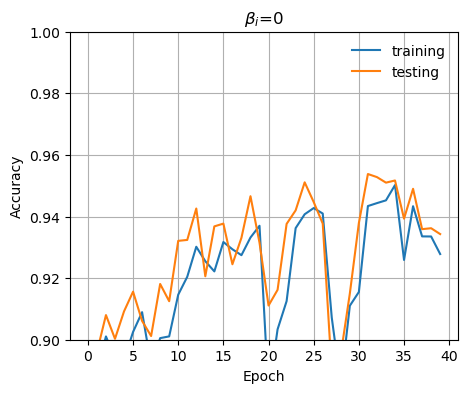

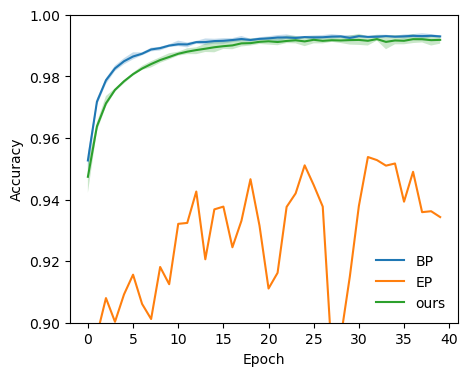

In [9]:

     
for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"EP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")


plt.figure(figsize=(5, 4))
for labels, res in zip(['BP', 'EP', 'ours'], [res_BP, res_EP, res_aEP]):
    ifbsc = 0
    # tt = res[ifbsc,:,1,:]
    # plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    # plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=labels)  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    # plt.grid()
    # plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
plt.savefig(res_path /f"EP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")